In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   frosinone
   2   savona
   3   avellino
   4   ragusa
   5   vibo_valentia
   6   lodi
   7   pistoia
   8   chieti
   9   piacenza
   10   pavia
   11   nuoro
   12   trapani
   13   caltanissetta
   14   asti
   15   carbonia
   16   bari
   17   pescara
   18   isernia
   19   verona
   20   udine
   21   salerno
   22   campobasso
   23   latina
   24   la_spezia
   25   novara
   26   vercelli
   27   l_aquila
   28   palermo
   29   gorizia
   30   reggio_nell_emilia
   31   lecco
   32   ferrara
   33   parma
   34   milano
   35   ancona
   36   cuneo
   37   caserta
   38   cosenza
   39   cagliari
   40   rovigo
   41   pordenone
   42   oristano
   43   siena
   44   foggia
   45   rieti
   46   pesaro
   47   taranto
   48   sassari
   49   varese
   50   sondrio
   51   bat
   52   padova
   53   trieste
   54   biella
   55   monza
   56   ascoli_piceno
   57   potenza
   58   napoli
   59   

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 frosinone
2 savona
3 avellino
4 ragusa
5 vibo_valentia
6 lodi
7 pistoia
8 chieti
9 piacenza
10 pavia
11 nuoro
12 trapani
13 caltanissetta
14 asti
15 bari
16 pescara
17 verona
18 udine
19 salerno
20 campobasso
21 latina
22 la_spezia
23 novara
24 vercelli
25 l_aquila
26 palermo
27 gorizia
28 reggio_nell_emilia
29 lecco
30 ferrara
31 parma
32 milano
33 ancona
34 cuneo
35 caserta
36 cosenza
37 cagliari
38 rovigo
39 pordenone
40 oristano
41 siena
42 foggia
43 rieti
44 pesaro
45 taranto
46 sassari
47 varese
48 sondrio
49 bat
50 padova
51 trieste
52 biella
53 monza
54 ascoli_piceno
55 potenza
56 napoli
57 vicenza
58 arezzo
59 crotone
60 firenze
61 trento
62 catanzaro
63 rimini
64 belluno
65 treviso
66 agrigento
67 macerata
68 modena
69 genova
70 bergamo
71 viterbo
72 livorno
73 como
74 brescia
75 messina
76 forli
77 brindisi
78 fermo
79 verbania
80 lecce
81 teramo
82 ravenna
83 pisa
84 mantova
85 reggio_di_calabria
86 bolzano
87 prato
88 perugia
89 venezia
90 matera
91 roma
92 alessandria
9

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

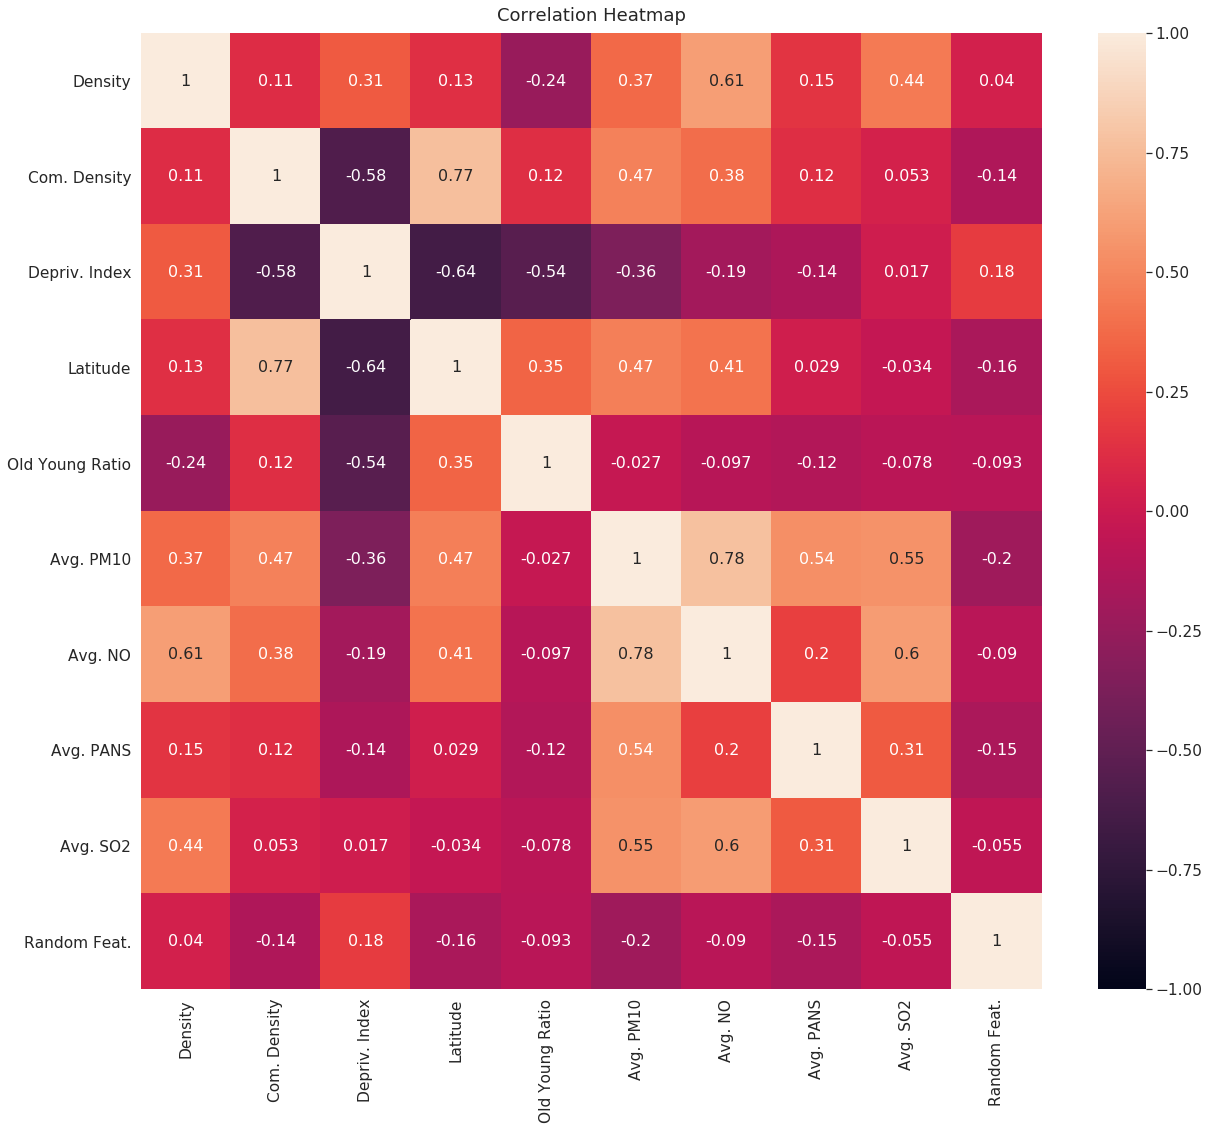

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34306  0.02151 
    Test set average RMSE:  0.93529  0.08821 

Prediction STD :  1.29373575742858
True value STD:   1.4782591096169262
Difference in percentage:  12.482476920853433

             Fullset RMSE:  0.33724
                       R2:  0.94795


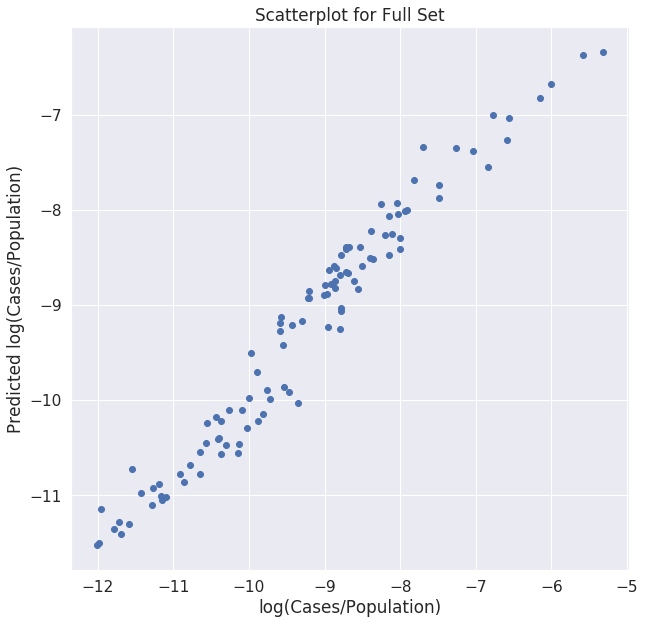

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04949 +/- 0.00598
Feature:               commutersdensity, Score: 0.02838 +/- 0.00326
Feature:                         depriv, Score: 0.04049 +/- 0.00543
Feature:                            lat, Score: 2.81009 +/- 0.35960
Feature:                 Ratio0200ver65, Score: 0.14386 +/- 0.01937
Feature:         avg_wpm10_period1_2020, Score: 0.15149 +/- 0.01878
Feature:           avg_wno_period1_2020, Score: 0.16180 +/- 0.01857
Feature:         avg_wpans_period1_2020, Score: 0.04238 +/- 0.00562
Feature:          avg_wso2_period1_2020, Score: 0.05606 +/- 0.00849
Feature:                  randomfeature, Score: 0.11660 +/- 0.02141


<Figure size 432x288 with 0 Axes>

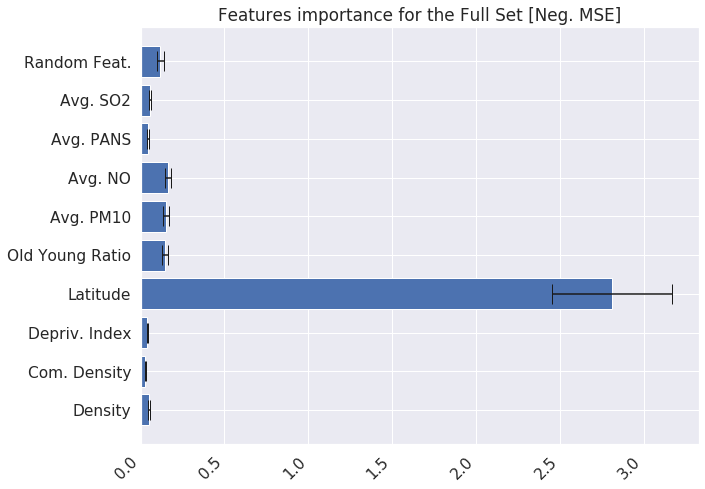

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02265 +/- 0.00273
Feature:               commutersdensity, Score: 0.01299 +/- 0.00149
Feature:                         depriv, Score: 0.01853 +/- 0.00249
Feature:                            lat, Score: 1.28594 +/- 0.16456
Feature:                 Ratio0200ver65, Score: 0.06583 +/- 0.00886
Feature:         avg_wpm10_period1_2020, Score: 0.06932 +/- 0.00859
Feature:           avg_wno_period1_2020, Score: 0.07404 +/- 0.00850
Feature:         avg_wpans_period1_2020, Score: 0.01940 +/- 0.00257
Feature:          avg_wso2_period1_2020, Score: 0.02565 +/- 0.00389
Feature:                  randomfeature, Score: 0.05336 +/- 0.00980


<Figure size 432x288 with 0 Axes>

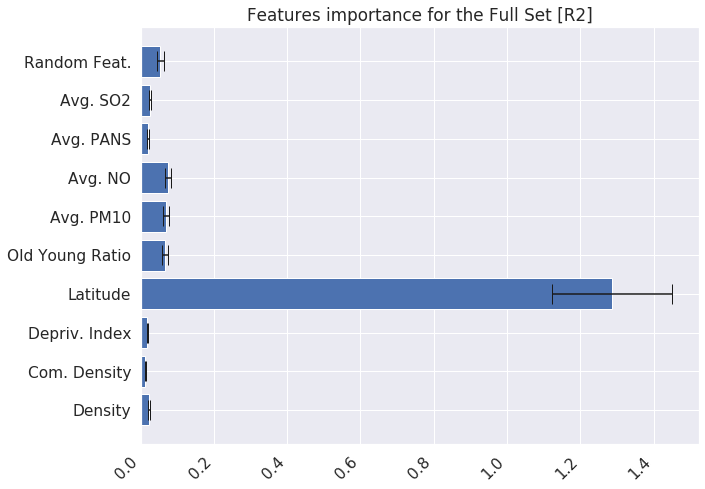

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

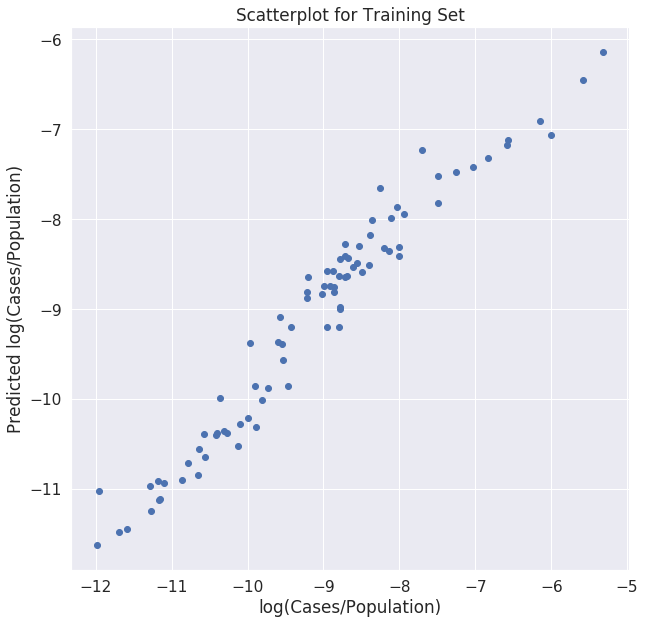

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

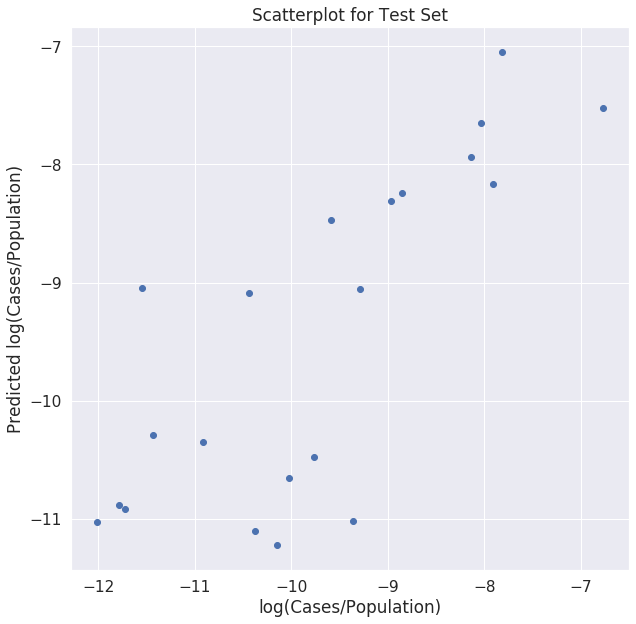

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.02505 +/- 0.01688
Feature:               commutersdensity, Score: -0.01391 +/- 0.02532
Feature:                         depriv, Score: -0.02258 +/- 0.02480
Feature:                            lat, Score: 2.43960 +/- 0.72113
Feature:                 Ratio0200ver65, Score: 0.11890 +/- 0.05833
Feature:         avg_wpm10_period1_2020, Score: 0.02412 +/- 0.03165
Feature:           avg_wno_period1_2020, Score: -0.00178 +/- 0.05693
Feature:         avg_wpans_period1_2020, Score: 0.01985 +/- 0.03332
Feature:          avg_wso2_period1_2020, Score: -0.01409 +/- 0.01525
Feature:                  randomfeature, Score: 0.00102 +/- 0.05143


<Figure size 432x288 with 0 Axes>

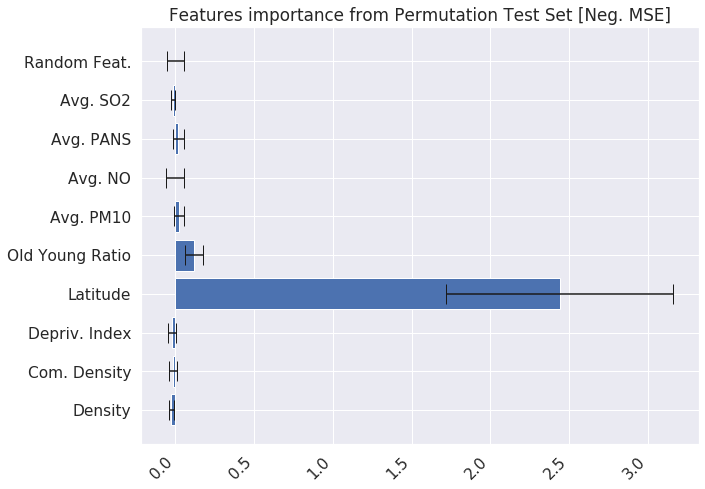

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01170 +/- 0.00788
Feature:               commutersdensity, Score: -0.00650 +/- 0.01182
Feature:                         depriv, Score: -0.01054 +/- 0.01158
Feature:                            lat, Score: 1.13904 +/- 0.33669
Feature:                 Ratio0200ver65, Score: 0.05551 +/- 0.02723
Feature:         avg_wpm10_period1_2020, Score: 0.01126 +/- 0.01478
Feature:           avg_wno_period1_2020, Score: -0.00083 +/- 0.02658
Feature:         avg_wpans_period1_2020, Score: 0.00927 +/- 0.01556
Feature:          avg_wso2_period1_2020, Score: -0.00658 +/- 0.00712
Feature:                  randomfeature, Score: 0.00048 +/- 0.02401


<Figure size 432x288 with 0 Axes>

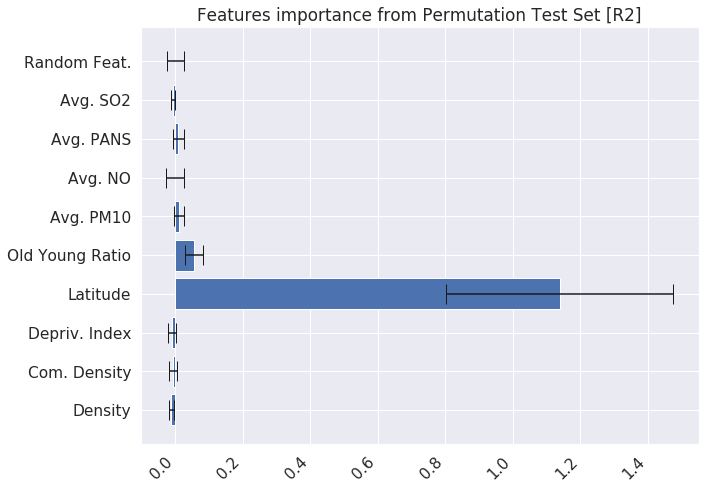

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05052 +/- 0.00737
Feature:               commutersdensity, Score: 0.02217 +/- 0.00384
Feature:                         depriv, Score: 0.03452 +/- 0.00523
Feature:                            lat, Score: 2.62824 +/- 0.39778
Feature:                 Ratio0200ver65, Score: 0.15087 +/- 0.03202
Feature:         avg_wpm10_period1_2020, Score: 0.14291 +/- 0.03016
Feature:           avg_wno_period1_2020, Score: 0.09683 +/- 0.01491
Feature:         avg_wpans_period1_2020, Score: 0.06726 +/- 0.01071
Feature:          avg_wso2_period1_2020, Score: 0.03973 +/- 0.00462
Feature:                  randomfeature, Score: 0.12373 +/- 0.02361


<Figure size 432x288 with 0 Axes>

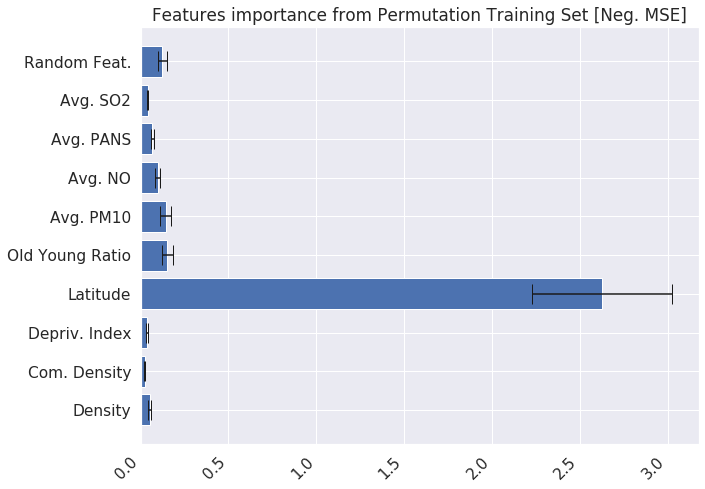

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02388 +/- 0.00348
Feature:               commutersdensity, Score: 0.01048 +/- 0.00182
Feature:                         depriv, Score: 0.01632 +/- 0.00247
Feature:                            lat, Score: 1.24232 +/- 0.18802
Feature:                 Ratio0200ver65, Score: 0.07131 +/- 0.01513
Feature:         avg_wpm10_period1_2020, Score: 0.06755 +/- 0.01426
Feature:           avg_wno_period1_2020, Score: 0.04577 +/- 0.00705
Feature:         avg_wpans_period1_2020, Score: 0.03179 +/- 0.00506
Feature:          avg_wso2_period1_2020, Score: 0.01878 +/- 0.00218
Feature:                  randomfeature, Score: 0.05849 +/- 0.01116


<Figure size 432x288 with 0 Axes>

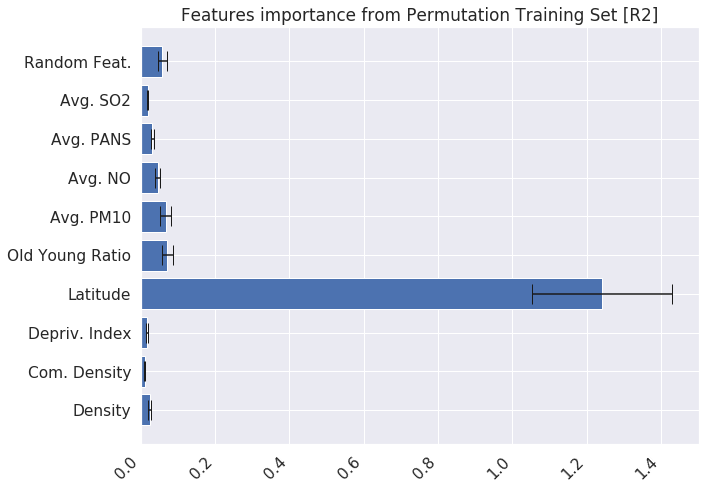

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36590  0.02486 
    Test set average RMSE:  1.01239  0.10403 

Prediction STD :  1.2627953035555977
True value STD:   1.4782591096169262
Difference in percentage:  14.575510115893248

             Fullset RMSE:  0.35803
                       R2:  0.94134


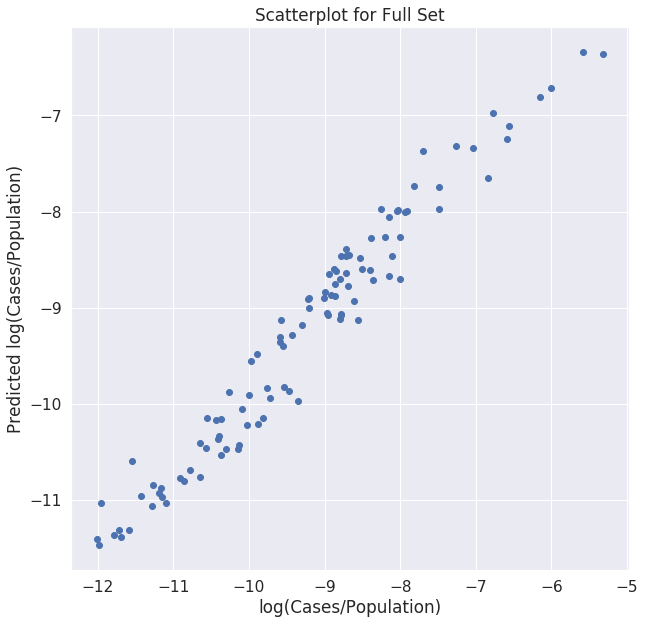

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06481 +/- 0.00827
Feature:               commutersdensity, Score: 1.71592 +/- 0.23165
Feature:                         depriv, Score: 0.06508 +/- 0.00874
Feature:                 Ratio0200ver65, Score: 0.23601 +/- 0.03216
Feature:         avg_wpm10_period1_2020, Score: 0.19287 +/- 0.02903
Feature:           avg_wno_period1_2020, Score: 0.29548 +/- 0.03713
Feature:         avg_wpans_period1_2020, Score: 0.06515 +/- 0.01027
Feature:          avg_wso2_period1_2020, Score: 0.07025 +/- 0.00986
Feature:                  randomfeature, Score: 0.13578 +/- 0.02007


<Figure size 432x288 with 0 Axes>

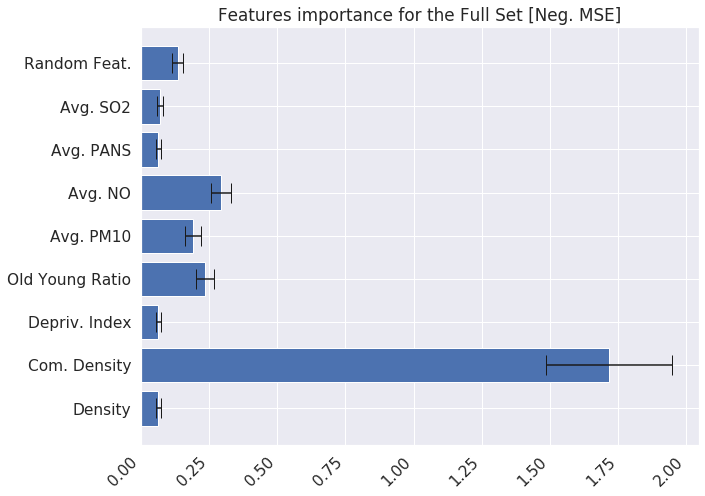

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02966 +/- 0.00378
Feature:               commutersdensity, Score: 0.78523 +/- 0.10601
Feature:                         depriv, Score: 0.02978 +/- 0.00400
Feature:                 Ratio0200ver65, Score: 0.10800 +/- 0.01472
Feature:         avg_wpm10_period1_2020, Score: 0.08826 +/- 0.01328
Feature:           avg_wno_period1_2020, Score: 0.13522 +/- 0.01699
Feature:         avg_wpans_period1_2020, Score: 0.02981 +/- 0.00470
Feature:          avg_wso2_period1_2020, Score: 0.03215 +/- 0.00451
Feature:                  randomfeature, Score: 0.06214 +/- 0.00918


<Figure size 432x288 with 0 Axes>

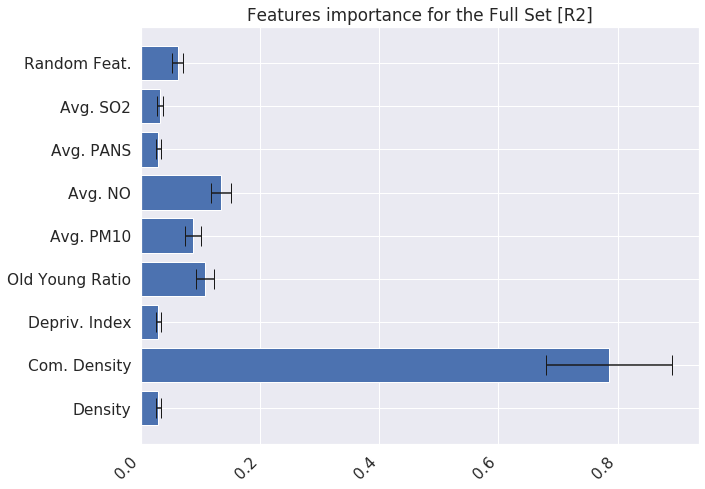

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

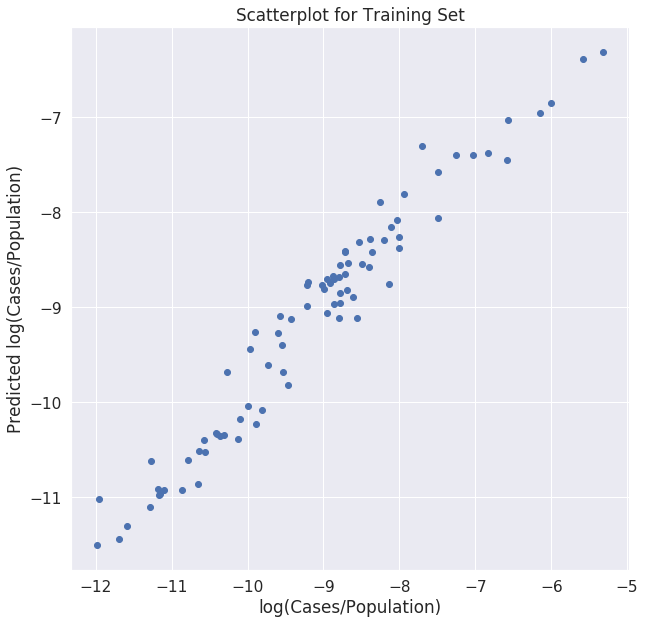

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

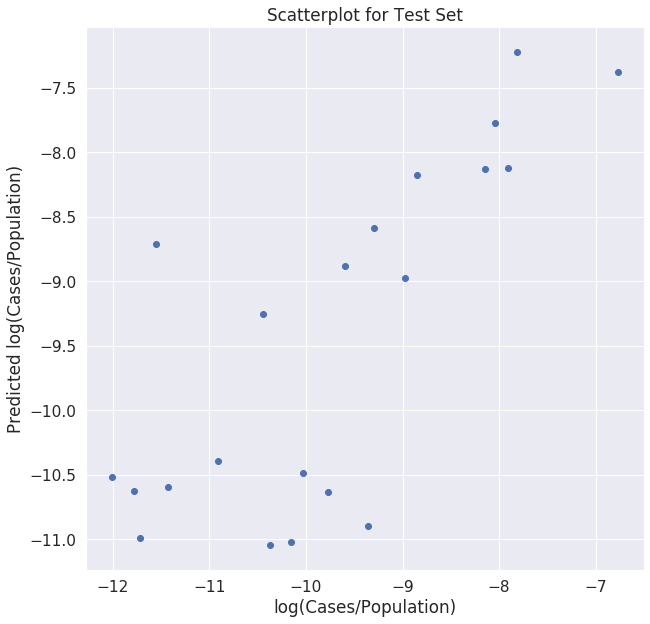

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.04808 +/- 0.03125
Feature:               commutersdensity, Score: 1.68999 +/- 0.54785
Feature:                         depriv, Score: -0.01016 +/- 0.05037
Feature:                 Ratio0200ver65, Score: 0.15453 +/- 0.09488
Feature:         avg_wpm10_period1_2020, Score: 0.10706 +/- 0.07456
Feature:           avg_wno_period1_2020, Score: 0.08556 +/- 0.06684
Feature:         avg_wpans_period1_2020, Score: 0.01642 +/- 0.05118
Feature:          avg_wso2_period1_2020, Score: -0.00148 +/- 0.03726
Feature:                  randomfeature, Score: -0.00553 +/- 0.04491


<Figure size 432x288 with 0 Axes>

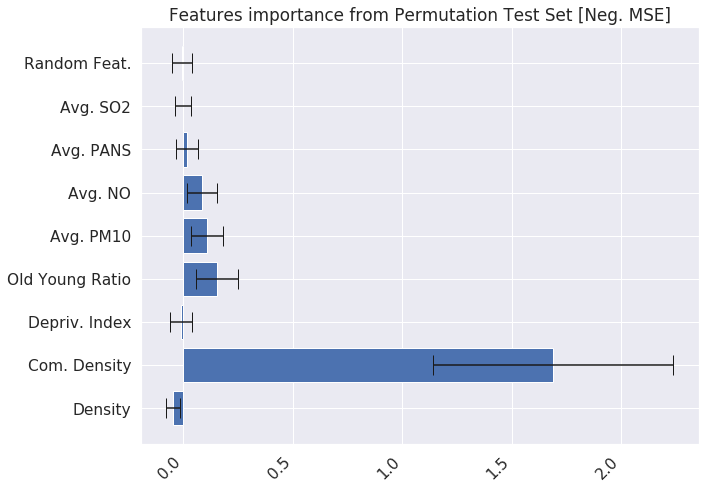

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.02245 +/- 0.01459
Feature:               commutersdensity, Score: 0.78905 +/- 0.25579
Feature:                         depriv, Score: -0.00474 +/- 0.02352
Feature:                 Ratio0200ver65, Score: 0.07215 +/- 0.04430
Feature:         avg_wpm10_period1_2020, Score: 0.04999 +/- 0.03481
Feature:           avg_wno_period1_2020, Score: 0.03995 +/- 0.03121
Feature:         avg_wpans_period1_2020, Score: 0.00767 +/- 0.02390
Feature:          avg_wso2_period1_2020, Score: -0.00069 +/- 0.01740
Feature:                  randomfeature, Score: -0.00258 +/- 0.02097


<Figure size 432x288 with 0 Axes>

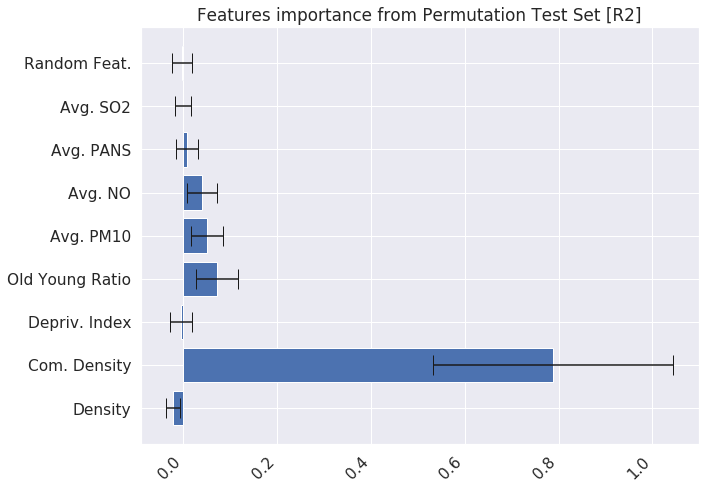

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07464 +/- 0.01186
Feature:               commutersdensity, Score: 1.77353 +/- 0.28848
Feature:                         depriv, Score: 0.08355 +/- 0.01465
Feature:                 Ratio0200ver65, Score: 0.26873 +/- 0.04352
Feature:         avg_wpm10_period1_2020, Score: 0.18804 +/- 0.03679
Feature:           avg_wno_period1_2020, Score: 0.18972 +/- 0.03278
Feature:         avg_wpans_period1_2020, Score: 0.09371 +/- 0.01600
Feature:          avg_wso2_period1_2020, Score: 0.07576 +/- 0.00947
Feature:                  randomfeature, Score: 0.14498 +/- 0.02289


<Figure size 432x288 with 0 Axes>

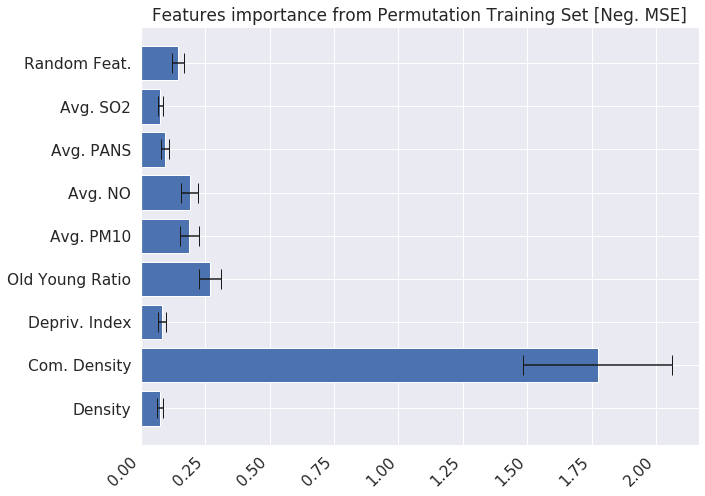

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03528 +/- 0.00561
Feature:               commutersdensity, Score: 0.83832 +/- 0.13636
Feature:                         depriv, Score: 0.03949 +/- 0.00692
Feature:                 Ratio0200ver65, Score: 0.12703 +/- 0.02057
Feature:         avg_wpm10_period1_2020, Score: 0.08889 +/- 0.01739
Feature:           avg_wno_period1_2020, Score: 0.08968 +/- 0.01549
Feature:         avg_wpans_period1_2020, Score: 0.04430 +/- 0.00756
Feature:          avg_wso2_period1_2020, Score: 0.03581 +/- 0.00448
Feature:                  randomfeature, Score: 0.06853 +/- 0.01082


<Figure size 432x288 with 0 Axes>

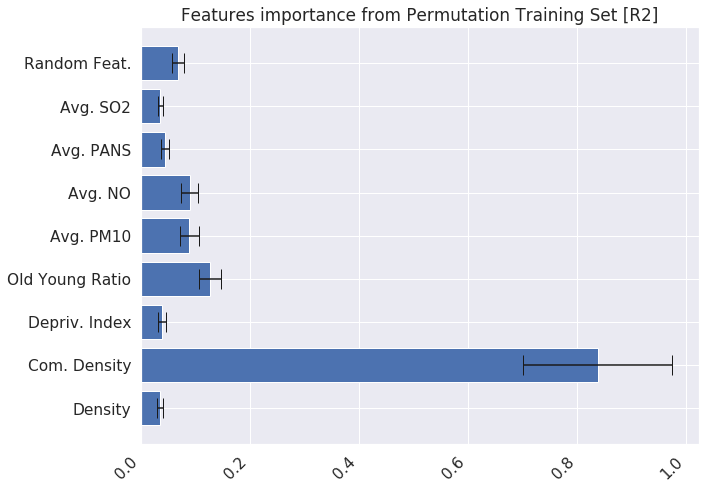

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39600  0.02184 
    Test set average RMSE:  1.03725  0.10994 

Prediction STD :  1.22309821128032
True value STD:   1.4782591096169262
Difference in percentage:  17.260904849267476

             Fullset RMSE:  0.37744
                       R2:  0.93481


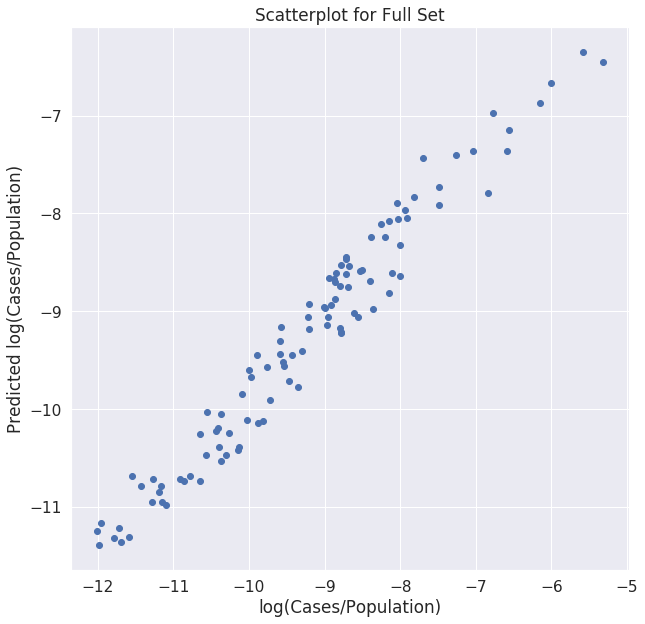

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05793 +/- 0.00616
Feature:                         depriv, Score: 0.59431 +/- 0.09200
Feature:                 Ratio0200ver65, Score: 0.19299 +/- 0.02421
Feature:         avg_wpm10_period1_2020, Score: 0.34209 +/- 0.04729
Feature:           avg_wno_period1_2020, Score: 0.95350 +/- 0.12258
Feature:         avg_wpans_period1_2020, Score: 0.11770 +/- 0.01573
Feature:          avg_wso2_period1_2020, Score: 0.09134 +/- 0.00953
Feature:                  randomfeature, Score: 0.11922 +/- 0.01863


<Figure size 432x288 with 0 Axes>

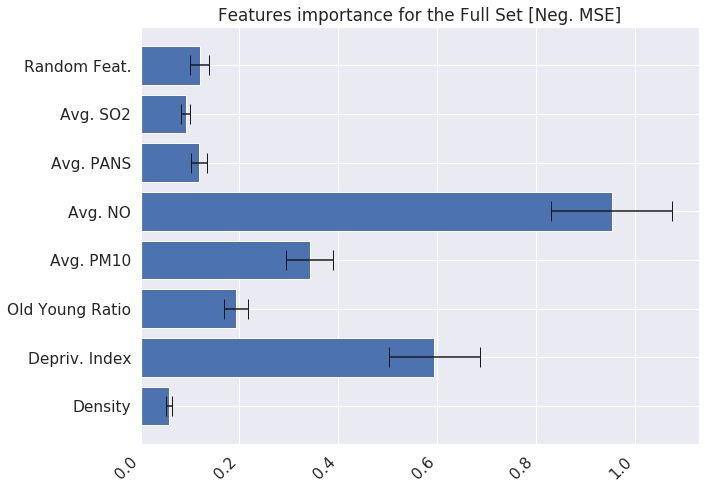

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02651 +/- 0.00282
Feature:                         depriv, Score: 0.27197 +/- 0.04210
Feature:                 Ratio0200ver65, Score: 0.08831 +/- 0.01108
Feature:         avg_wpm10_period1_2020, Score: 0.15655 +/- 0.02164
Feature:           avg_wno_period1_2020, Score: 0.43634 +/- 0.05609
Feature:         avg_wpans_period1_2020, Score: 0.05386 +/- 0.00720
Feature:          avg_wso2_period1_2020, Score: 0.04180 +/- 0.00436
Feature:                  randomfeature, Score: 0.05456 +/- 0.00853


<Figure size 432x288 with 0 Axes>

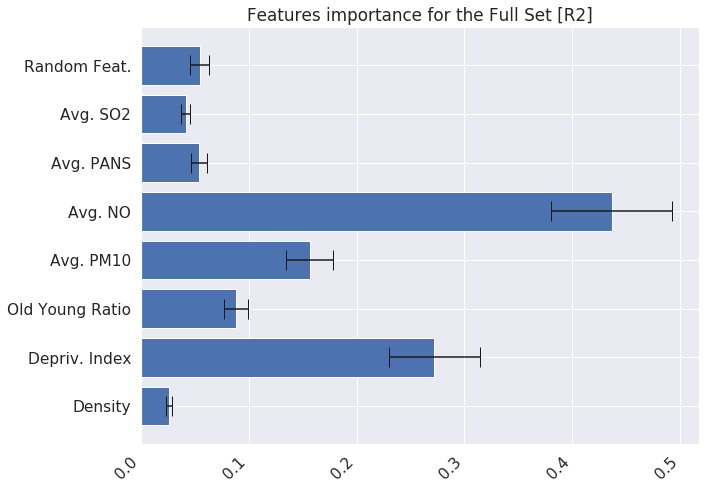

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

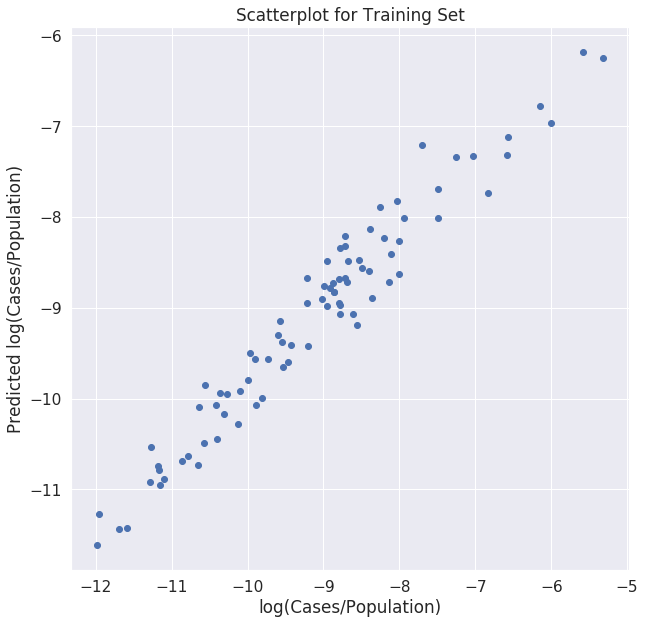

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

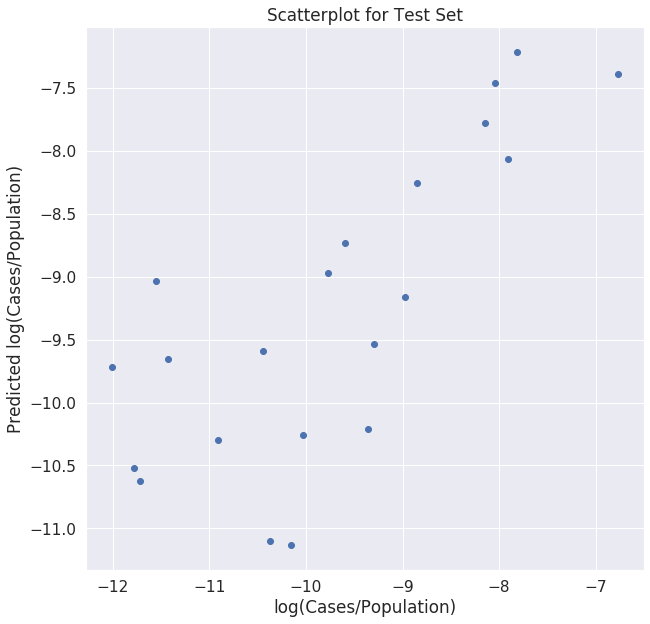

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.01700 +/- 0.03515
Feature:                         depriv, Score: 0.41348 +/- 0.25786
Feature:                 Ratio0200ver65, Score: 0.03775 +/- 0.04066
Feature:         avg_wpm10_period1_2020, Score: 0.26198 +/- 0.11962
Feature:           avg_wno_period1_2020, Score: 0.60594 +/- 0.22340
Feature:         avg_wpans_period1_2020, Score: 0.08845 +/- 0.08160
Feature:          avg_wso2_period1_2020, Score: -0.00632 +/- 0.03306
Feature:                  randomfeature, Score: -0.05055 +/- 0.04758


<Figure size 432x288 with 0 Axes>

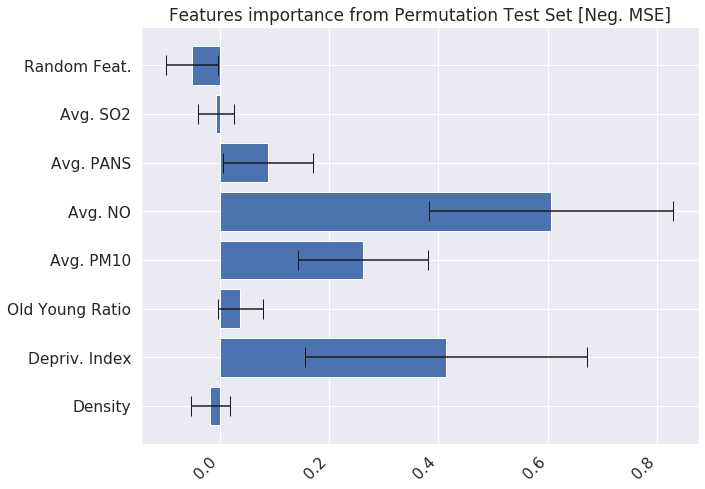

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00794 +/- 0.01641
Feature:                         depriv, Score: 0.19305 +/- 0.12039
Feature:                 Ratio0200ver65, Score: 0.01762 +/- 0.01899
Feature:         avg_wpm10_period1_2020, Score: 0.12232 +/- 0.05585
Feature:           avg_wno_period1_2020, Score: 0.28291 +/- 0.10431
Feature:         avg_wpans_period1_2020, Score: 0.04130 +/- 0.03810
Feature:          avg_wso2_period1_2020, Score: -0.00295 +/- 0.01544
Feature:                  randomfeature, Score: -0.02360 +/- 0.02222


<Figure size 432x288 with 0 Axes>

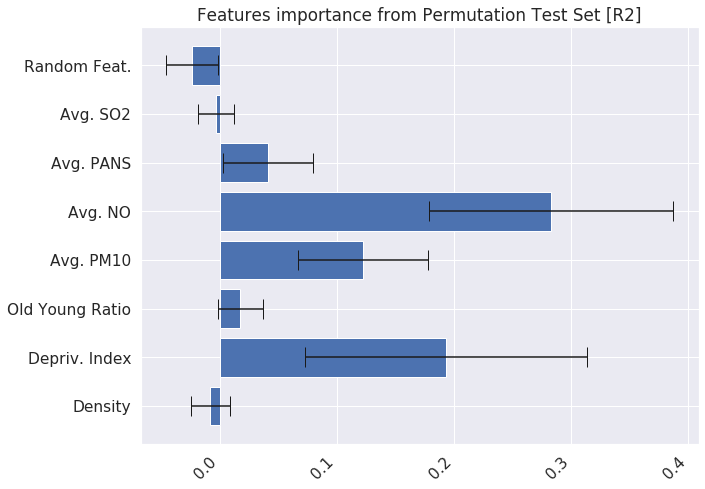

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07908 +/- 0.01156
Feature:                         depriv, Score: 0.87959 +/- 0.13679
Feature:                 Ratio0200ver65, Score: 0.14372 +/- 0.02534
Feature:         avg_wpm10_period1_2020, Score: 0.32562 +/- 0.06490
Feature:           avg_wno_period1_2020, Score: 0.60335 +/- 0.11380
Feature:         avg_wpans_period1_2020, Score: 0.12859 +/- 0.02133
Feature:          avg_wso2_period1_2020, Score: 0.08201 +/- 0.01151
Feature:                  randomfeature, Score: 0.17746 +/- 0.02755


<Figure size 432x288 with 0 Axes>

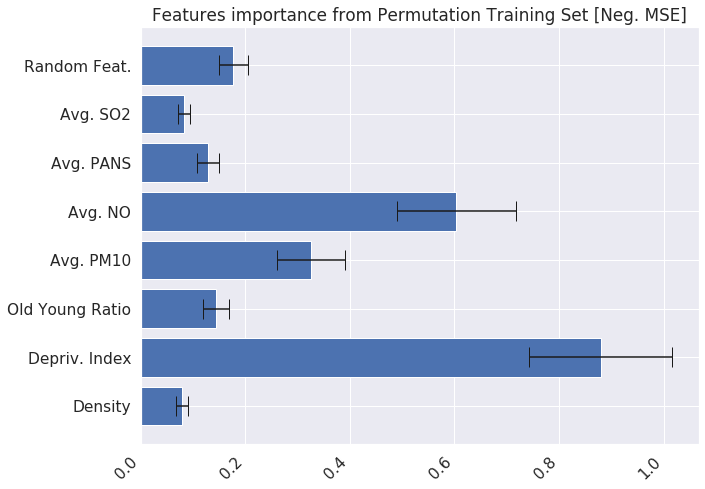

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03738 +/- 0.00546
Feature:                         depriv, Score: 0.41577 +/- 0.06466
Feature:                 Ratio0200ver65, Score: 0.06794 +/- 0.01198
Feature:         avg_wpm10_period1_2020, Score: 0.15391 +/- 0.03068
Feature:           avg_wno_period1_2020, Score: 0.28519 +/- 0.05379
Feature:         avg_wpans_period1_2020, Score: 0.06078 +/- 0.01008
Feature:          avg_wso2_period1_2020, Score: 0.03877 +/- 0.00544
Feature:                  randomfeature, Score: 0.08388 +/- 0.01302


<Figure size 432x288 with 0 Axes>

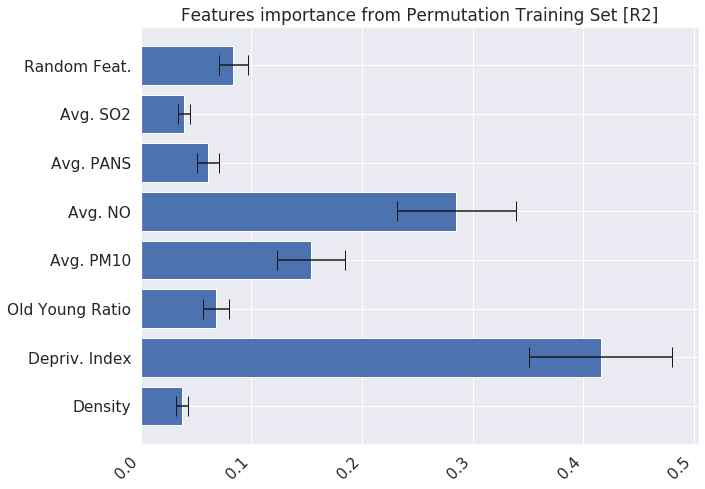

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34111  0.02274 
    Test set average RMSE:  0.94334  0.09642 

Prediction STD :  1.2961293039549933
True value STD:   1.4782591096169262
Difference in percentage:  12.320560345413991

             Fullset RMSE:  0.33801
                       R2:  0.94772


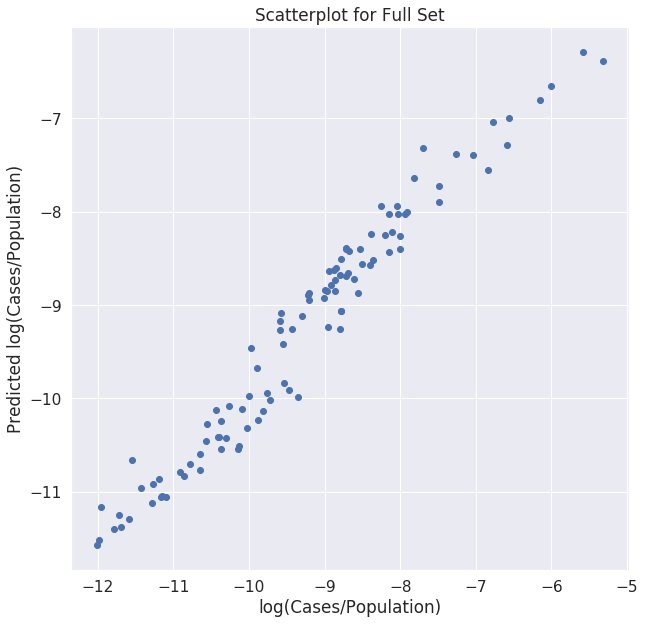

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04322 +/- 0.00616
Feature:               commutersdensity, Score: 0.02861 +/- 0.00362
Feature:                         depriv, Score: 0.04041 +/- 0.00420
Feature:                            lat, Score: 2.80091 +/- 0.35968
Feature:                 Ratio0200ver65, Score: 0.18054 +/- 0.02511
Feature:         avg_wpm10_period1_2020, Score: 0.13908 +/- 0.01748
Feature:           avg_wno_period1_2020, Score: 0.18194 +/- 0.02091
Feature:         avg_wpans_period1_2020, Score: 0.05022 +/- 0.00588
Feature:          avg_wso2_period1_2020, Score: 0.06038 +/- 0.00942
Feature:                  randomfeature, Score: 0.10005 +/- 0.01891


<Figure size 432x288 with 0 Axes>

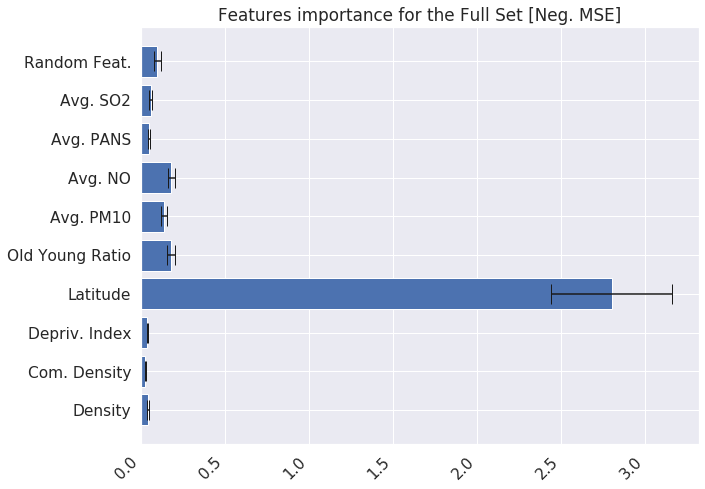

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.01978 +/- 0.00282
Feature:               commutersdensity, Score: 0.01309 +/- 0.00165
Feature:                         depriv, Score: 0.01849 +/- 0.00192
Feature:                            lat, Score: 1.28173 +/- 0.16460
Feature:                 Ratio0200ver65, Score: 0.08262 +/- 0.01149
Feature:         avg_wpm10_period1_2020, Score: 0.06364 +/- 0.00800
Feature:           avg_wno_period1_2020, Score: 0.08326 +/- 0.00957
Feature:         avg_wpans_period1_2020, Score: 0.02298 +/- 0.00269
Feature:          avg_wso2_period1_2020, Score: 0.02763 +/- 0.00431
Feature:                  randomfeature, Score: 0.04578 +/- 0.00865


<Figure size 432x288 with 0 Axes>

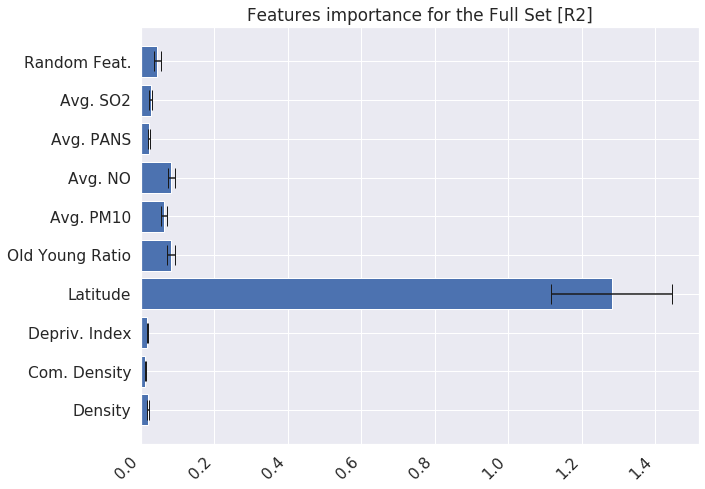

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

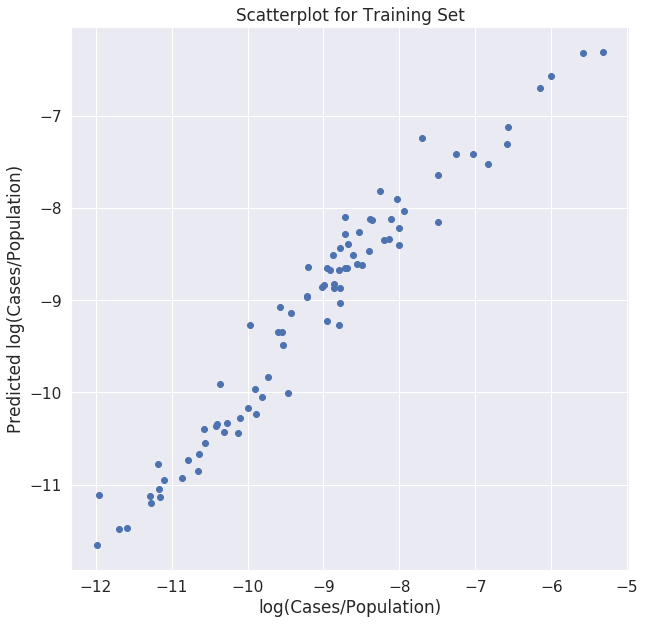

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

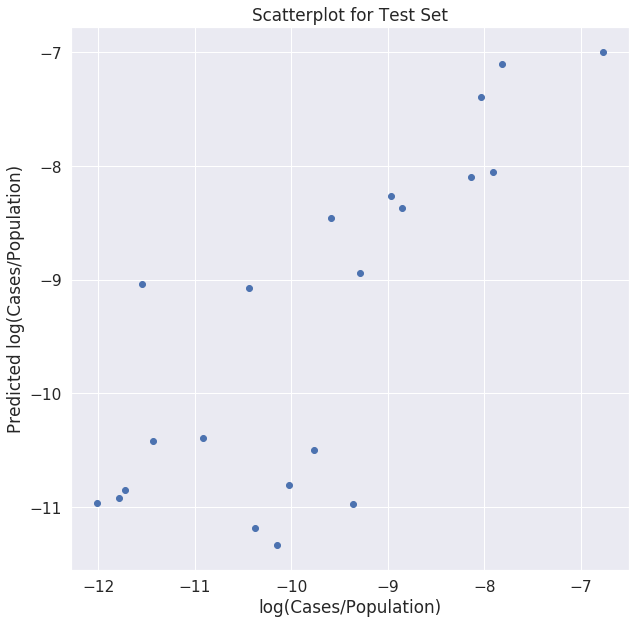

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00048 +/- 0.01358
Feature:               commutersdensity, Score: -0.01004 +/- 0.02549
Feature:                         depriv, Score: -0.00977 +/- 0.02994
Feature:                            lat, Score: 2.41667 +/- 0.72765
Feature:                 Ratio0200ver65, Score: 0.09008 +/- 0.03736
Feature:         avg_wpm10_period1_2020, Score: 0.02030 +/- 0.03090
Feature:           avg_wno_period1_2020, Score: 0.01171 +/- 0.05374
Feature:         avg_wpans_period1_2020, Score: 0.01589 +/- 0.03419
Feature:          avg_wso2_period1_2020, Score: -0.00543 +/- 0.01662
Feature:                  randomfeature, Score: -0.02232 +/- 0.04027


<Figure size 432x288 with 0 Axes>

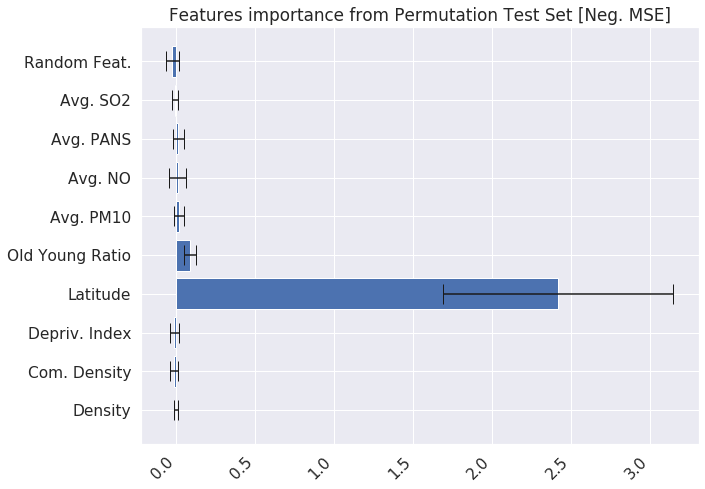

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00022 +/- 0.00634
Feature:               commutersdensity, Score: -0.00469 +/- 0.01190
Feature:                         depriv, Score: -0.00456 +/- 0.01398
Feature:                            lat, Score: 1.12834 +/- 0.33974
Feature:                 Ratio0200ver65, Score: 0.04206 +/- 0.01744
Feature:         avg_wpm10_period1_2020, Score: 0.00948 +/- 0.01443
Feature:           avg_wno_period1_2020, Score: 0.00547 +/- 0.02509
Feature:         avg_wpans_period1_2020, Score: 0.00742 +/- 0.01596
Feature:          avg_wso2_period1_2020, Score: -0.00254 +/- 0.00776
Feature:                  randomfeature, Score: -0.01042 +/- 0.01880


<Figure size 432x288 with 0 Axes>

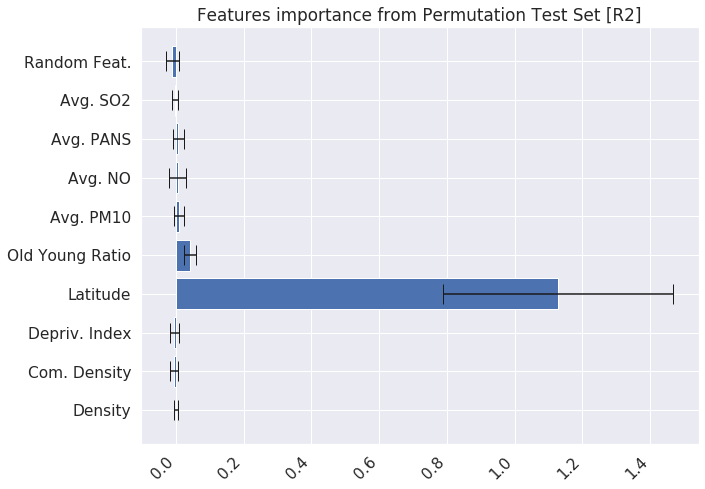

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04687 +/- 0.00614
Feature:               commutersdensity, Score: 0.02453 +/- 0.00381
Feature:                         depriv, Score: 0.03942 +/- 0.00593
Feature:                            lat, Score: 2.56146 +/- 0.37677
Feature:                 Ratio0200ver65, Score: 0.12326 +/- 0.02758
Feature:         avg_wpm10_period1_2020, Score: 0.12479 +/- 0.02602
Feature:           avg_wno_period1_2020, Score: 0.12361 +/- 0.02218
Feature:         avg_wpans_period1_2020, Score: 0.06902 +/- 0.01102
Feature:          avg_wso2_period1_2020, Score: 0.04984 +/- 0.00725
Feature:                  randomfeature, Score: 0.14046 +/- 0.02625


<Figure size 432x288 with 0 Axes>

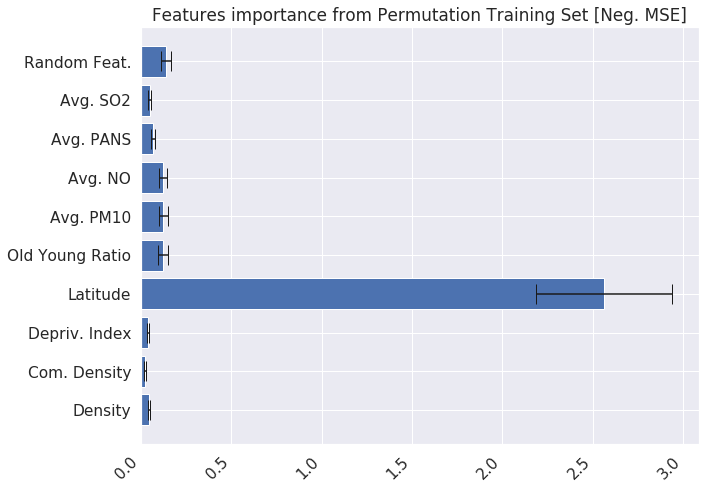

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02216 +/- 0.00290
Feature:               commutersdensity, Score: 0.01159 +/- 0.00180
Feature:                         depriv, Score: 0.01863 +/- 0.00280
Feature:                            lat, Score: 1.21076 +/- 0.17809
Feature:                 Ratio0200ver65, Score: 0.05826 +/- 0.01303
Feature:         avg_wpm10_period1_2020, Score: 0.05899 +/- 0.01230
Feature:           avg_wno_period1_2020, Score: 0.05843 +/- 0.01048
Feature:         avg_wpans_period1_2020, Score: 0.03262 +/- 0.00521
Feature:          avg_wso2_period1_2020, Score: 0.02356 +/- 0.00343
Feature:                  randomfeature, Score: 0.06639 +/- 0.01241


<Figure size 432x288 with 0 Axes>

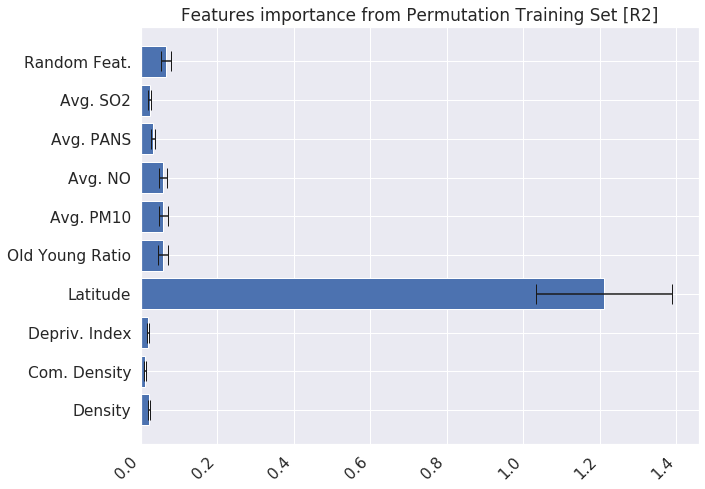

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37080  0.02216 
    Test set average RMSE:  0.98164  0.11284 

Prediction STD :  1.2627953035555977
True value STD:   1.4782591096169262
Difference in percentage:  14.575510115893248

             Fullset RMSE:  0.35803
                       R2:  0.94134


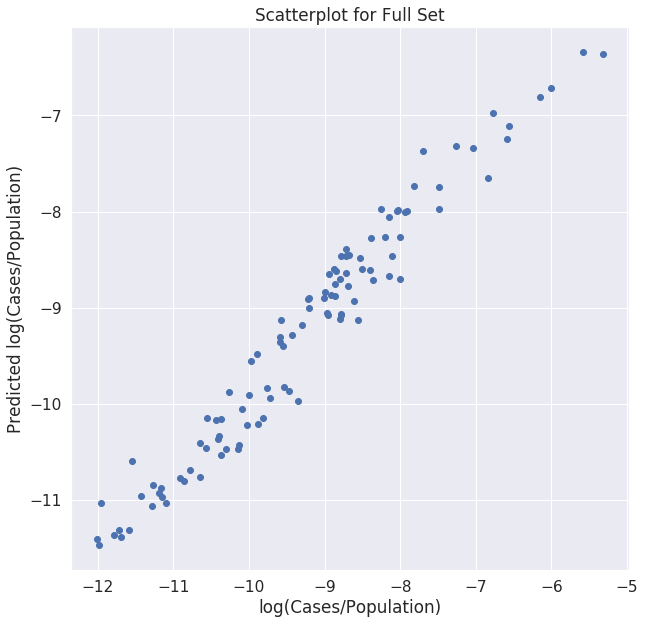

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05316 +/- 0.00663
Feature:               commutersdensity, Score: 1.68457 +/- 0.23068
Feature:                         depriv, Score: 0.06471 +/- 0.00837
Feature:                 Ratio0200ver65, Score: 0.24110 +/- 0.03432
Feature:         avg_wpm10_period1_2020, Score: 0.20803 +/- 0.02807
Feature:           avg_wno_period1_2020, Score: 0.31427 +/- 0.03942
Feature:         avg_wpans_period1_2020, Score: 0.06308 +/- 0.00978
Feature:          avg_wso2_period1_2020, Score: 0.08728 +/- 0.01028
Feature:                  randomfeature, Score: 0.13853 +/- 0.02201


<Figure size 432x288 with 0 Axes>

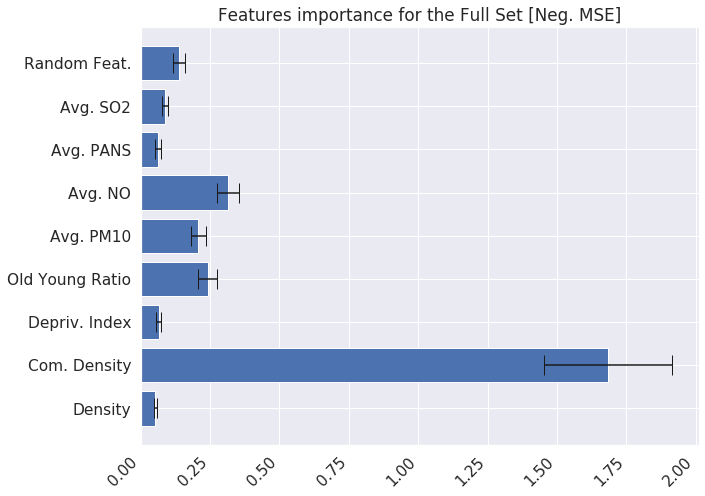

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02433 +/- 0.00304
Feature:               commutersdensity, Score: 0.77088 +/- 0.10556
Feature:                         depriv, Score: 0.02961 +/- 0.00383
Feature:                 Ratio0200ver65, Score: 0.11033 +/- 0.01571
Feature:         avg_wpm10_period1_2020, Score: 0.09520 +/- 0.01284
Feature:           avg_wno_period1_2020, Score: 0.14381 +/- 0.01804
Feature:         avg_wpans_period1_2020, Score: 0.02887 +/- 0.00447
Feature:          avg_wso2_period1_2020, Score: 0.03994 +/- 0.00470
Feature:                  randomfeature, Score: 0.06340 +/- 0.01007


<Figure size 432x288 with 0 Axes>

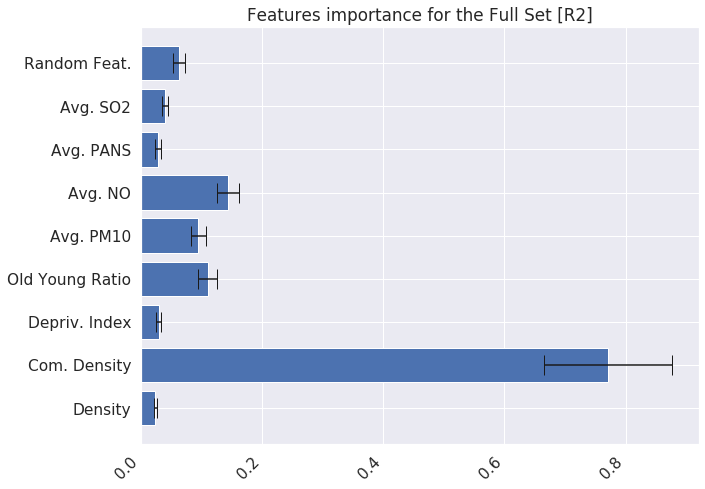

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

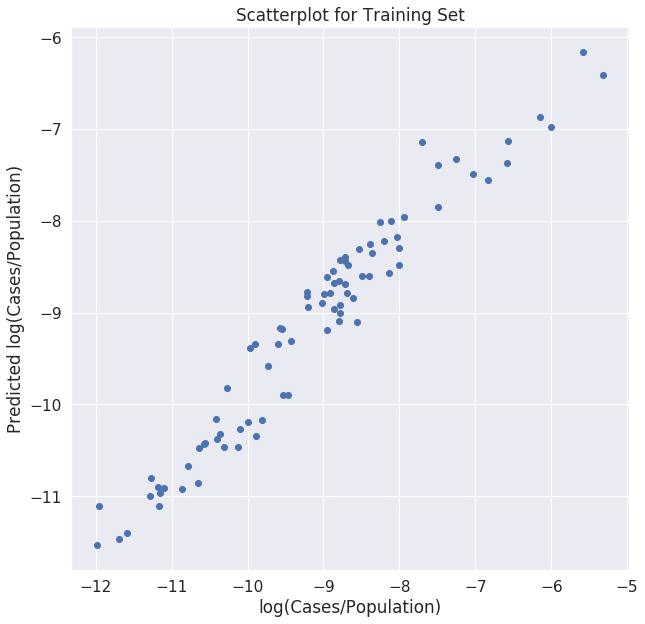

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

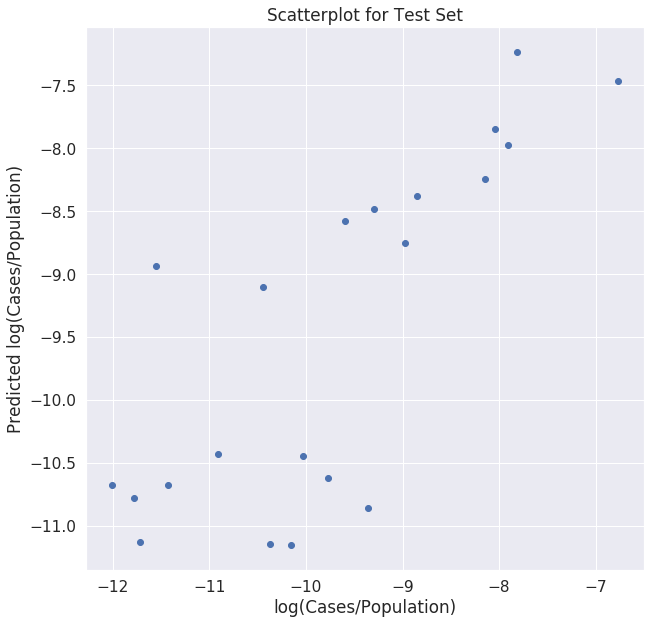

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00697 +/- 0.02139
Feature:               commutersdensity, Score: 1.65568 +/- 0.54274
Feature:                         depriv, Score: -0.01255 +/- 0.05520
Feature:                 Ratio0200ver65, Score: 0.15574 +/- 0.08384
Feature:         avg_wpm10_period1_2020, Score: 0.08447 +/- 0.05915
Feature:           avg_wno_period1_2020, Score: 0.10453 +/- 0.07666
Feature:         avg_wpans_period1_2020, Score: 0.01569 +/- 0.03860
Feature:          avg_wso2_period1_2020, Score: 0.01705 +/- 0.02890
Feature:                  randomfeature, Score: -0.00210 +/- 0.03562


<Figure size 432x288 with 0 Axes>

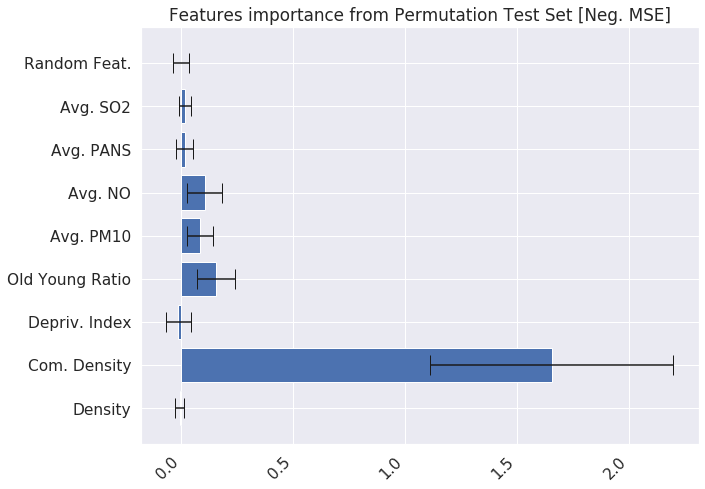

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00325 +/- 0.00999
Feature:               commutersdensity, Score: 0.77303 +/- 0.25340
Feature:                         depriv, Score: -0.00586 +/- 0.02577
Feature:                 Ratio0200ver65, Score: 0.07271 +/- 0.03914
Feature:         avg_wpm10_period1_2020, Score: 0.03944 +/- 0.02762
Feature:           avg_wno_period1_2020, Score: 0.04881 +/- 0.03579
Feature:         avg_wpans_period1_2020, Score: 0.00733 +/- 0.01802
Feature:          avg_wso2_period1_2020, Score: 0.00796 +/- 0.01349
Feature:                  randomfeature, Score: -0.00098 +/- 0.01663


<Figure size 432x288 with 0 Axes>

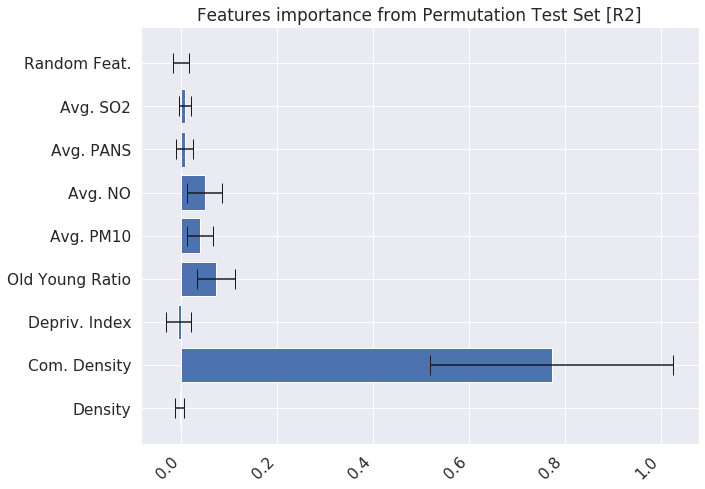

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07487 +/- 0.01163
Feature:               commutersdensity, Score: 1.76341 +/- 0.29241
Feature:                         depriv, Score: 0.08160 +/- 0.01548
Feature:                 Ratio0200ver65, Score: 0.21032 +/- 0.03234
Feature:         avg_wpm10_period1_2020, Score: 0.18120 +/- 0.03816
Feature:           avg_wno_period1_2020, Score: 0.18114 +/- 0.03331
Feature:         avg_wpans_period1_2020, Score: 0.09961 +/- 0.01539
Feature:          avg_wso2_period1_2020, Score: 0.06910 +/- 0.00868
Feature:                  randomfeature, Score: 0.14333 +/- 0.02095


<Figure size 432x288 with 0 Axes>

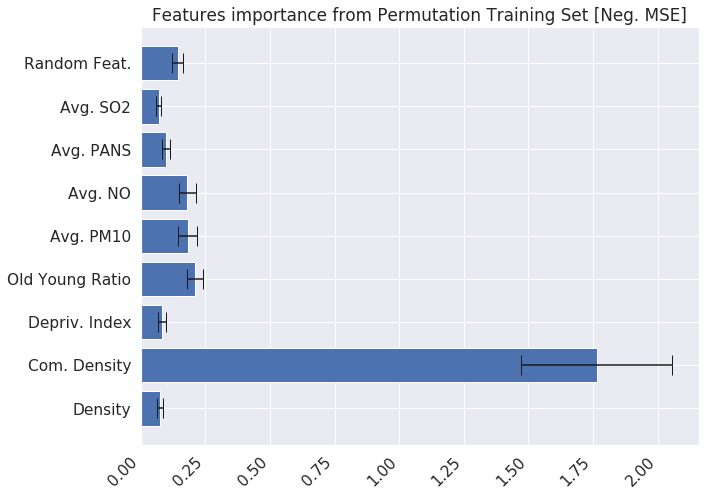

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03539 +/- 0.00550
Feature:               commutersdensity, Score: 0.83353 +/- 0.13822
Feature:                         depriv, Score: 0.03857 +/- 0.00732
Feature:                 Ratio0200ver65, Score: 0.09942 +/- 0.01529
Feature:         avg_wpm10_period1_2020, Score: 0.08565 +/- 0.01804
Feature:           avg_wno_period1_2020, Score: 0.08562 +/- 0.01574
Feature:         avg_wpans_period1_2020, Score: 0.04708 +/- 0.00727
Feature:          avg_wso2_period1_2020, Score: 0.03266 +/- 0.00410
Feature:                  randomfeature, Score: 0.06775 +/- 0.00990


<Figure size 432x288 with 0 Axes>

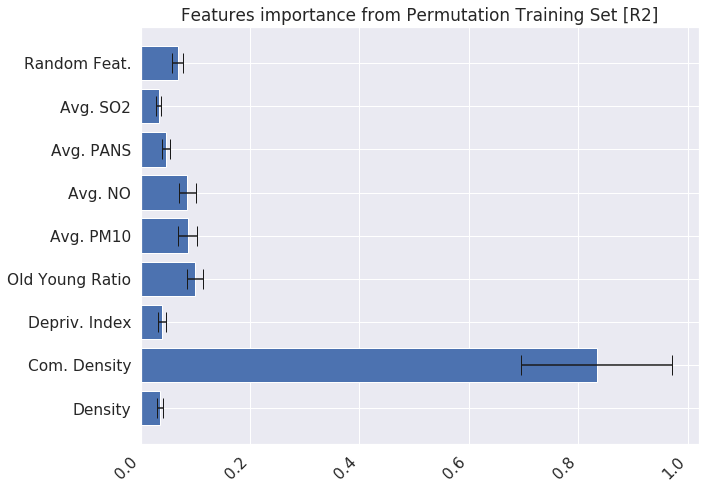

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39232  0.02543 
    Test set average RMSE:  1.03646  0.12229 

Prediction STD :  1.222871448028036
True value STD:   1.4782591096169262
Difference in percentage:  17.27624473459669

             Fullset RMSE:  0.37754
                       R2:  0.93477


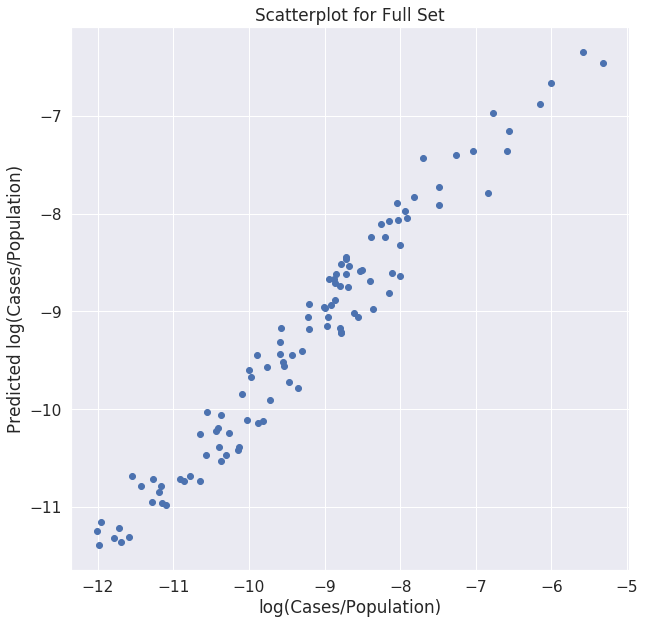

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04993 +/- 0.00598
Feature:                         depriv, Score: 0.54005 +/- 0.07999
Feature:                 Ratio0200ver65, Score: 0.20129 +/- 0.02452
Feature:         avg_wpm10_period1_2020, Score: 0.29983 +/- 0.04421
Feature:           avg_wno_period1_2020, Score: 1.12727 +/- 0.13605
Feature:         avg_wpans_period1_2020, Score: 0.10104 +/- 0.01271
Feature:          avg_wso2_period1_2020, Score: 0.09828 +/- 0.01039
Feature:                  randomfeature, Score: 0.12667 +/- 0.02079


<Figure size 432x288 with 0 Axes>

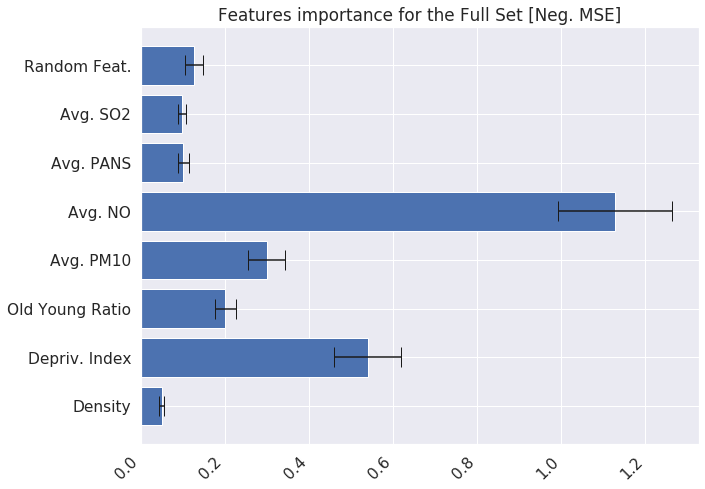

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02285 +/- 0.00274
Feature:                         depriv, Score: 0.24714 +/- 0.03661
Feature:                 Ratio0200ver65, Score: 0.09211 +/- 0.01122
Feature:         avg_wpm10_period1_2020, Score: 0.13720 +/- 0.02023
Feature:           avg_wno_period1_2020, Score: 0.51585 +/- 0.06226
Feature:         avg_wpans_period1_2020, Score: 0.04624 +/- 0.00582
Feature:          avg_wso2_period1_2020, Score: 0.04497 +/- 0.00476
Feature:                  randomfeature, Score: 0.05797 +/- 0.00951


<Figure size 432x288 with 0 Axes>

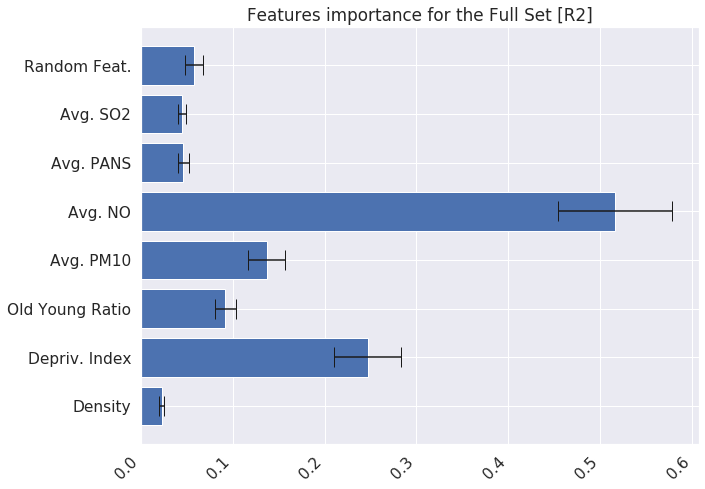

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

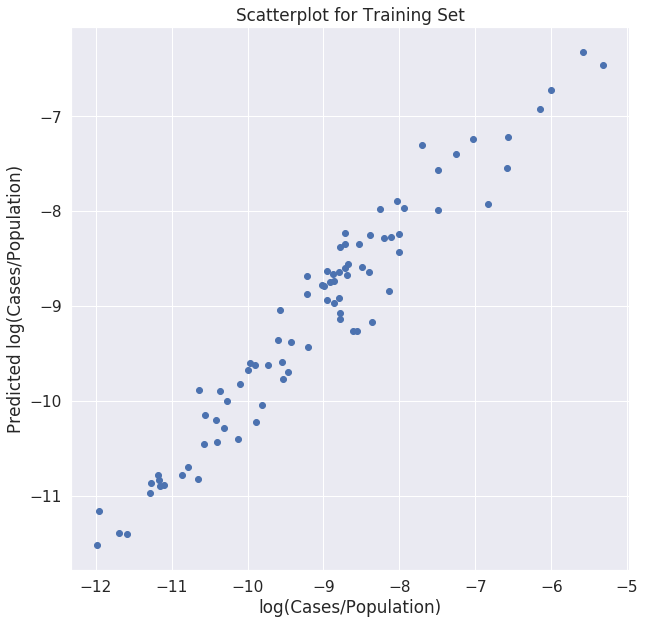

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

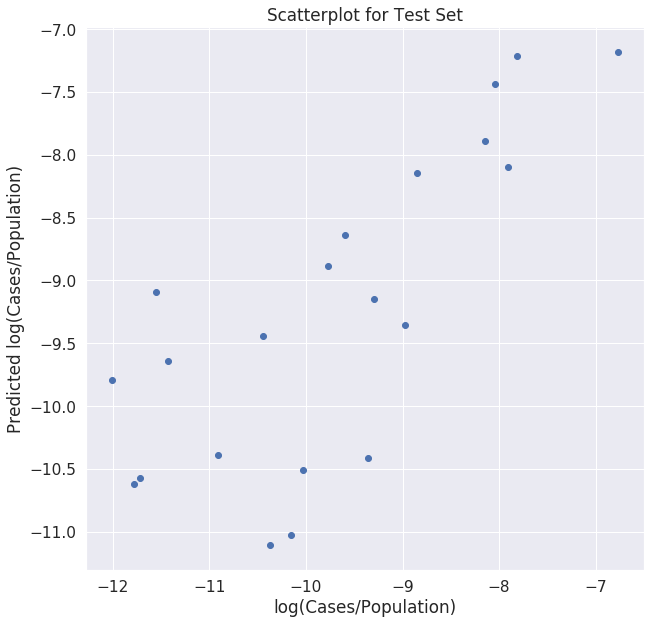

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.04420 +/- 0.03934
Feature:                         depriv, Score: 0.51113 +/- 0.26416
Feature:                 Ratio0200ver65, Score: 0.02902 +/- 0.04541
Feature:         avg_wpm10_period1_2020, Score: 0.13635 +/- 0.07486
Feature:           avg_wno_period1_2020, Score: 0.67004 +/- 0.23253
Feature:         avg_wpans_period1_2020, Score: 0.06195 +/- 0.06158
Feature:          avg_wso2_period1_2020, Score: -0.03706 +/- 0.02896
Feature:                  randomfeature, Score: -0.03849 +/- 0.04607


<Figure size 432x288 with 0 Axes>

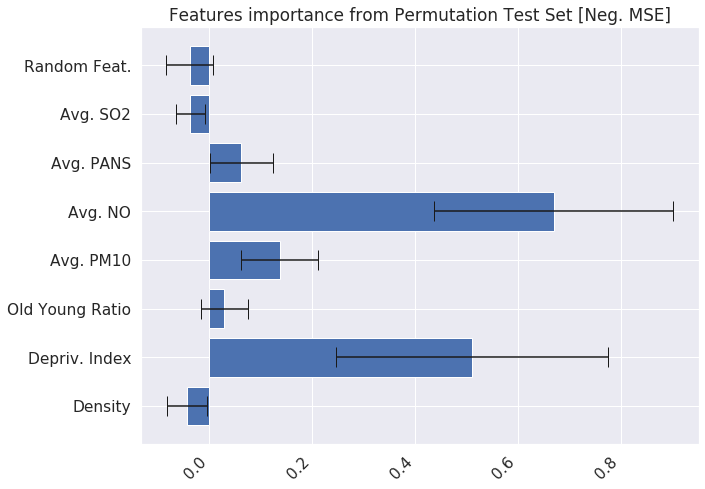

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.02063 +/- 0.01837
Feature:                         depriv, Score: 0.23865 +/- 0.12334
Feature:                 Ratio0200ver65, Score: 0.01355 +/- 0.02120
Feature:         avg_wpm10_period1_2020, Score: 0.06366 +/- 0.03495
Feature:           avg_wno_period1_2020, Score: 0.31284 +/- 0.10857
Feature:         avg_wpans_period1_2020, Score: 0.02893 +/- 0.02875
Feature:          avg_wso2_period1_2020, Score: -0.01730 +/- 0.01352
Feature:                  randomfeature, Score: -0.01797 +/- 0.02151


<Figure size 432x288 with 0 Axes>

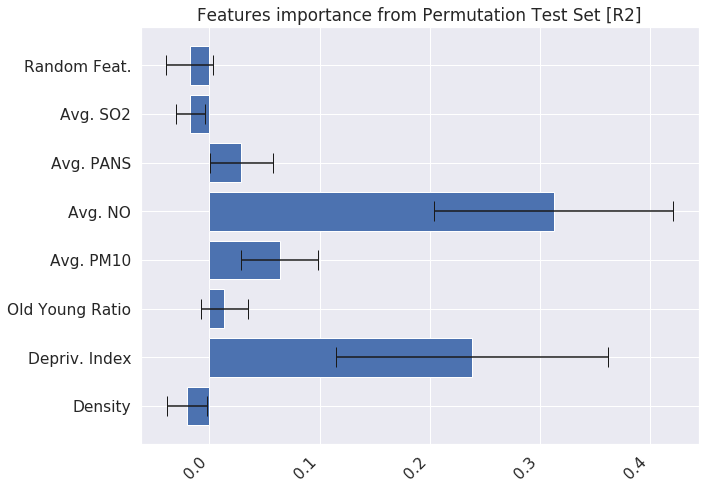

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.08419 +/- 0.01318
Feature:                         depriv, Score: 0.98998 +/- 0.15606
Feature:                 Ratio0200ver65, Score: 0.17292 +/- 0.02718
Feature:         avg_wpm10_period1_2020, Score: 0.21494 +/- 0.03644
Feature:           avg_wno_period1_2020, Score: 0.65065 +/- 0.12251
Feature:         avg_wpans_period1_2020, Score: 0.11136 +/- 0.01692
Feature:          avg_wso2_period1_2020, Score: 0.08225 +/- 0.01055
Feature:                  randomfeature, Score: 0.19382 +/- 0.02899


<Figure size 432x288 with 0 Axes>

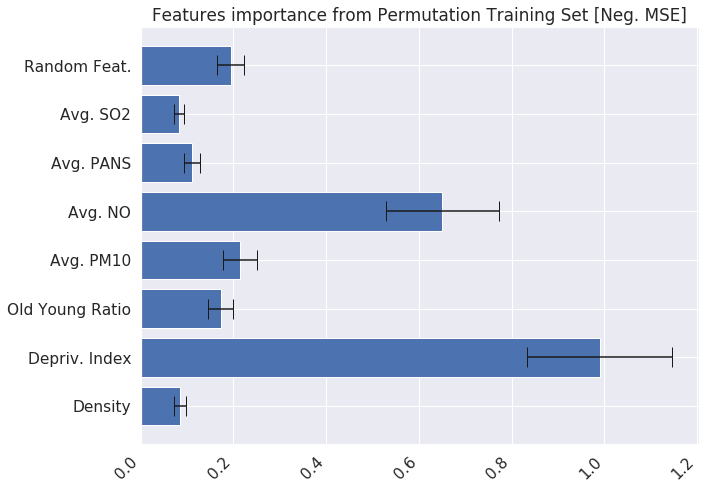

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03979 +/- 0.00623
Feature:                         depriv, Score: 0.46795 +/- 0.07377
Feature:                 Ratio0200ver65, Score: 0.08174 +/- 0.01285
Feature:         avg_wpm10_period1_2020, Score: 0.10160 +/- 0.01722
Feature:           avg_wno_period1_2020, Score: 0.30755 +/- 0.05791
Feature:         avg_wpans_period1_2020, Score: 0.05264 +/- 0.00800
Feature:          avg_wso2_period1_2020, Score: 0.03888 +/- 0.00499
Feature:                  randomfeature, Score: 0.09162 +/- 0.01371


<Figure size 432x288 with 0 Axes>

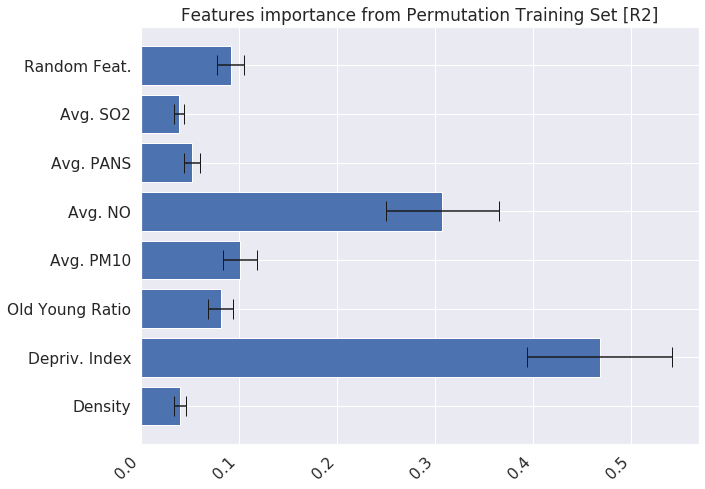

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.65944  0.03716 
    Test set average RMSE:  0.93730  0.09103 

Prediction STD :  1.2347459706020587
True value STD:   1.4782591096169262
Difference in percentage:  16.47296725118583

             Fullset RMSE:  0.63145
                       R2:  0.81754


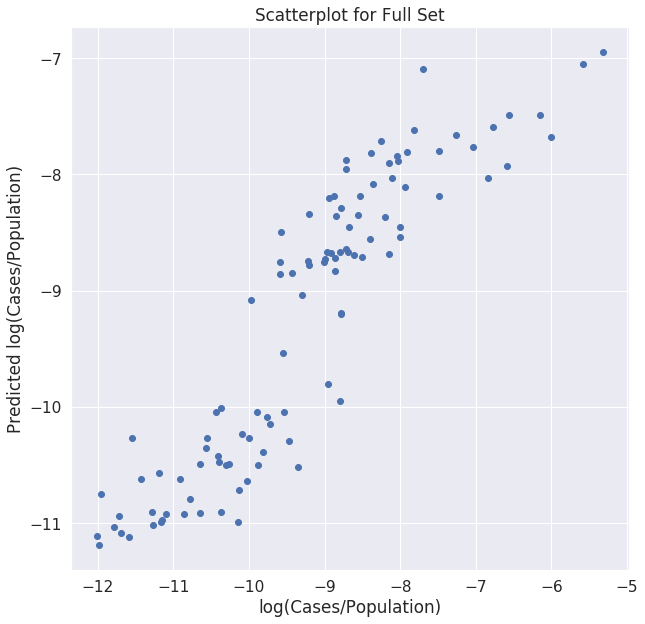

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05843 +/- 0.00748
Feature:               commutersdensity, Score: 0.03248 +/- 0.00400
Feature:                         depriv, Score: 0.04461 +/- 0.00451
Feature:                            lat, Score: 2.81617 +/- 0.36131
Feature:                 Ratio0200ver65, Score: 0.12625 +/- 0.01639
Feature:         avg_wpm10_period1_2020, Score: 0.16201 +/- 0.02131
Feature:           avg_wno_period1_2020, Score: 0.15482 +/- 0.01675
Feature:         avg_wpans_period1_2020, Score: 0.04101 +/- 0.00497
Feature:          avg_wso2_period1_2020, Score: 0.05611 +/- 0.00899
Feature:                  randomfeature, Score: 0.11046 +/- 0.01993


<Figure size 432x288 with 0 Axes>

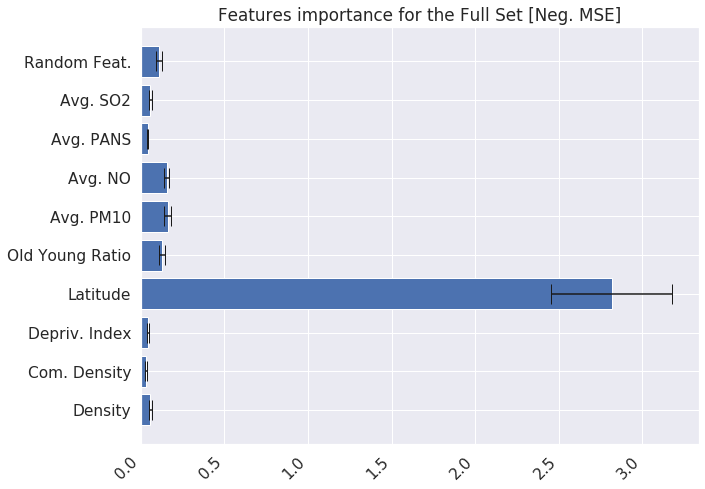

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02674 +/- 0.00342
Feature:               commutersdensity, Score: 0.01486 +/- 0.00183
Feature:                         depriv, Score: 0.02041 +/- 0.00206
Feature:                            lat, Score: 1.28872 +/- 0.16534
Feature:                 Ratio0200ver65, Score: 0.05777 +/- 0.00750
Feature:         avg_wpm10_period1_2020, Score: 0.07414 +/- 0.00975
Feature:           avg_wno_period1_2020, Score: 0.07085 +/- 0.00766
Feature:         avg_wpans_period1_2020, Score: 0.01877 +/- 0.00227
Feature:          avg_wso2_period1_2020, Score: 0.02568 +/- 0.00411
Feature:                  randomfeature, Score: 0.05055 +/- 0.00912


<Figure size 432x288 with 0 Axes>

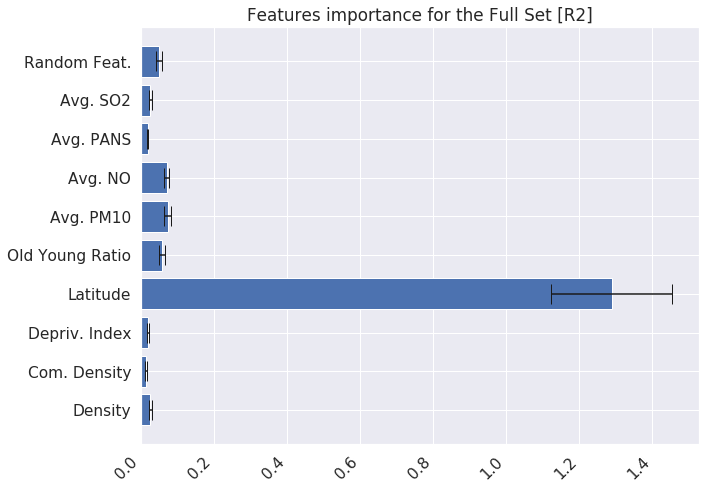

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

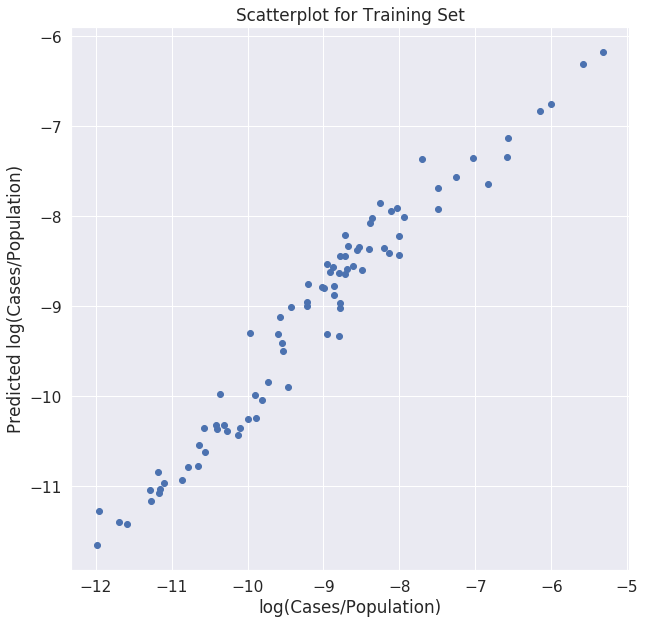

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

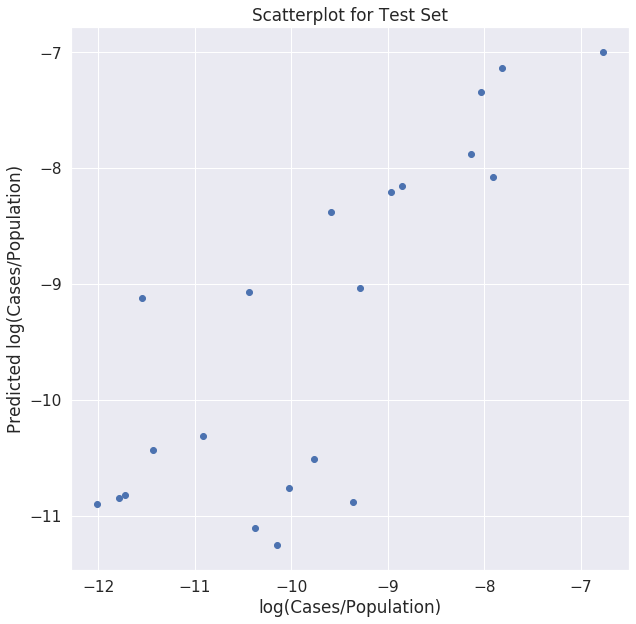

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.00267 +/- 0.01613
Feature:               commutersdensity, Score: 0.00034 +/- 0.01423
Feature:                         depriv, Score: -0.00617 +/- 0.02853
Feature:                            lat, Score: 2.46438 +/- 0.71842
Feature:                 Ratio0200ver65, Score: 0.09021 +/- 0.04184
Feature:         avg_wpm10_period1_2020, Score: 0.00560 +/- 0.03283
Feature:           avg_wno_period1_2020, Score: 0.00743 +/- 0.04366
Feature:         avg_wpans_period1_2020, Score: 0.00601 +/- 0.03568
Feature:          avg_wso2_period1_2020, Score: -0.00101 +/- 0.01375
Feature:                  randomfeature, Score: -0.01160 +/- 0.05636


<Figure size 432x288 with 0 Axes>

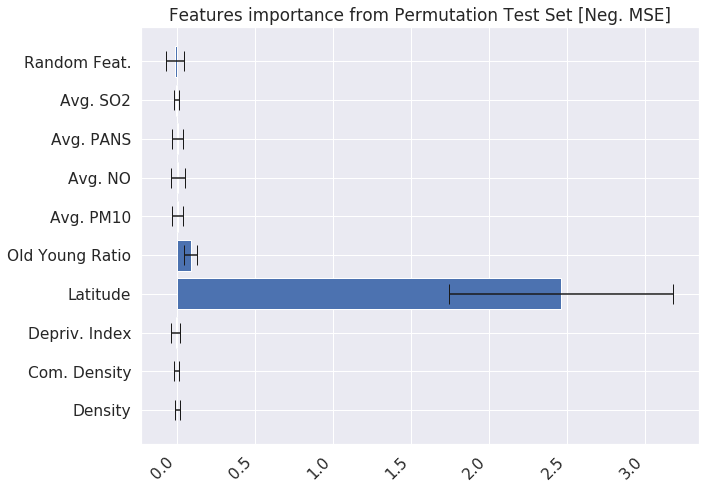

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: 0.00125 +/- 0.00753
Feature:               commutersdensity, Score: 0.00016 +/- 0.00664
Feature:                         depriv, Score: -0.00288 +/- 0.01332
Feature:                            lat, Score: 1.15062 +/- 0.33543
Feature:                 Ratio0200ver65, Score: 0.04212 +/- 0.01954
Feature:         avg_wpm10_period1_2020, Score: 0.00261 +/- 0.01533
Feature:           avg_wno_period1_2020, Score: 0.00347 +/- 0.02038
Feature:         avg_wpans_period1_2020, Score: 0.00281 +/- 0.01666
Feature:          avg_wso2_period1_2020, Score: -0.00047 +/- 0.00642
Feature:                  randomfeature, Score: -0.00542 +/- 0.02631


<Figure size 432x288 with 0 Axes>

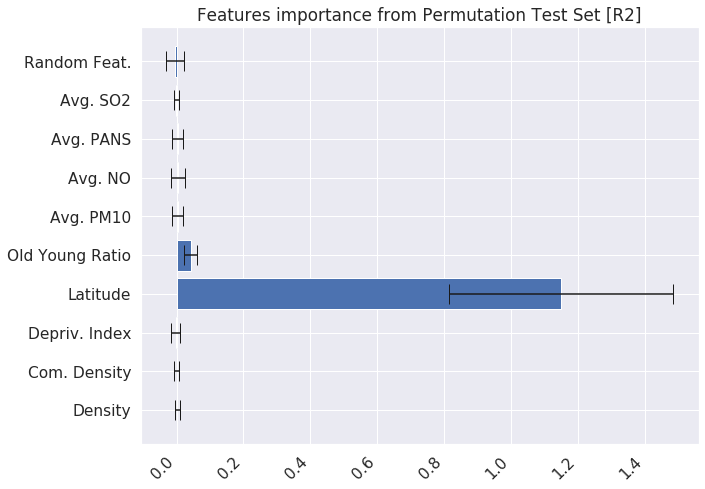

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04319 +/- 0.00807
Feature:               commutersdensity, Score: 0.01678 +/- 0.00279
Feature:                         depriv, Score: 0.03749 +/- 0.00540
Feature:                            lat, Score: 2.67407 +/- 0.39473
Feature:                 Ratio0200ver65, Score: 0.11986 +/- 0.02513
Feature:         avg_wpm10_period1_2020, Score: 0.13194 +/- 0.02440
Feature:           avg_wno_period1_2020, Score: 0.10749 +/- 0.01935
Feature:         avg_wpans_period1_2020, Score: 0.07600 +/- 0.01255
Feature:          avg_wso2_period1_2020, Score: 0.04868 +/- 0.00753
Feature:                  randomfeature, Score: 0.15224 +/- 0.02901


<Figure size 432x288 with 0 Axes>

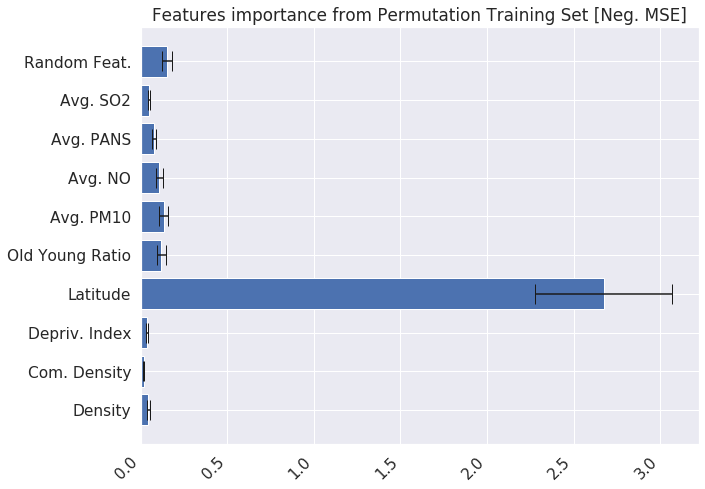

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.02042 +/- 0.00382
Feature:               commutersdensity, Score: 0.00793 +/- 0.00132
Feature:                         depriv, Score: 0.01772 +/- 0.00255
Feature:                            lat, Score: 1.26398 +/- 0.18658
Feature:                 Ratio0200ver65, Score: 0.05666 +/- 0.01188
Feature:         avg_wpm10_period1_2020, Score: 0.06237 +/- 0.01153
Feature:           avg_wno_period1_2020, Score: 0.05081 +/- 0.00915
Feature:         avg_wpans_period1_2020, Score: 0.03593 +/- 0.00593
Feature:          avg_wso2_period1_2020, Score: 0.02301 +/- 0.00356
Feature:                  randomfeature, Score: 0.07196 +/- 0.01371


<Figure size 432x288 with 0 Axes>

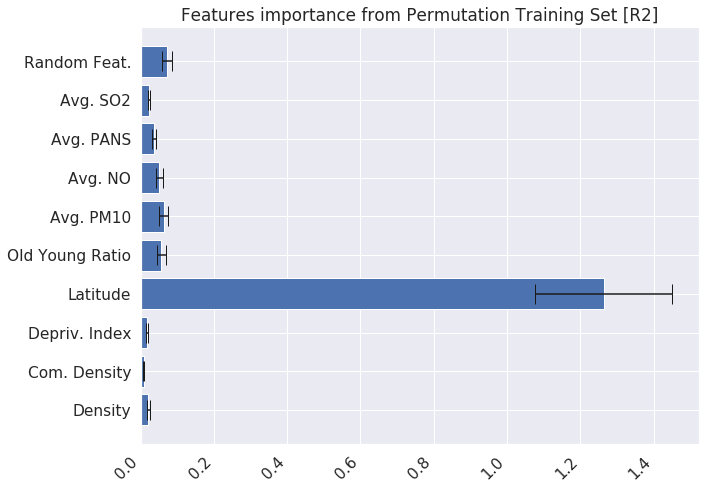

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="rf_model_allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.55517  0.03901 
    Test set average RMSE:  1.01771  0.10677 

Prediction STD :  1.176215313933677
True value STD:   1.4782591096169262
Difference in percentage:  20.432398739725695

             Fullset RMSE:  0.56470
                       R2:  0.85408


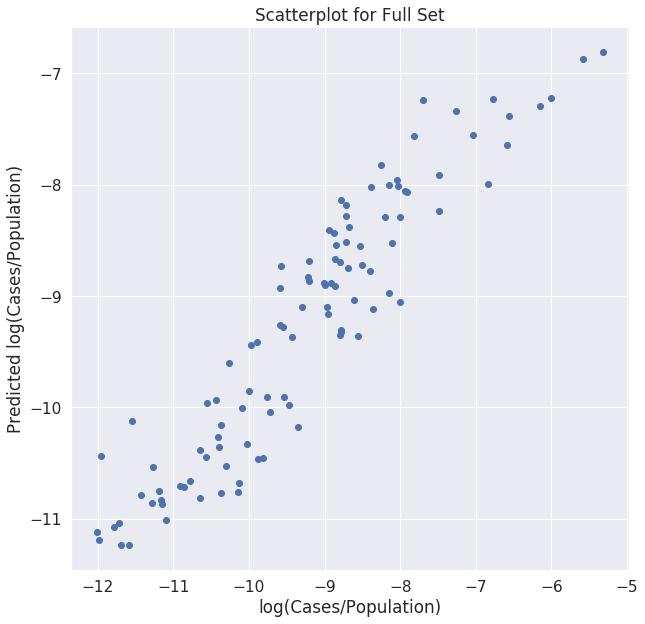

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.04969 +/- 0.00510
Feature:               commutersdensity, Score: 1.58756 +/- 0.21539
Feature:                         depriv, Score: 0.06563 +/- 0.00811
Feature:                 Ratio0200ver65, Score: 0.21167 +/- 0.02656
Feature:         avg_wpm10_period1_2020, Score: 0.22457 +/- 0.03322
Feature:           avg_wno_period1_2020, Score: 0.33064 +/- 0.04264
Feature:         avg_wpans_period1_2020, Score: 0.07310 +/- 0.01152
Feature:          avg_wso2_period1_2020, Score: 0.09308 +/- 0.01254
Feature:                  randomfeature, Score: 0.11335 +/- 0.01980


<Figure size 432x288 with 0 Axes>

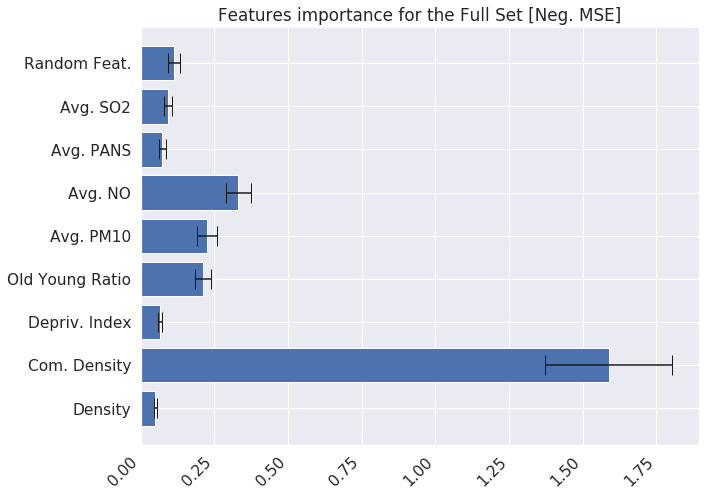

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.02274 +/- 0.00233
Feature:               commutersdensity, Score: 0.72649 +/- 0.09857
Feature:                         depriv, Score: 0.03003 +/- 0.00371
Feature:                 Ratio0200ver65, Score: 0.09686 +/- 0.01216
Feature:         avg_wpm10_period1_2020, Score: 0.10277 +/- 0.01520
Feature:           avg_wno_period1_2020, Score: 0.15130 +/- 0.01951
Feature:         avg_wpans_period1_2020, Score: 0.03345 +/- 0.00527
Feature:          avg_wso2_period1_2020, Score: 0.04259 +/- 0.00574
Feature:                  randomfeature, Score: 0.05187 +/- 0.00906


<Figure size 432x288 with 0 Axes>

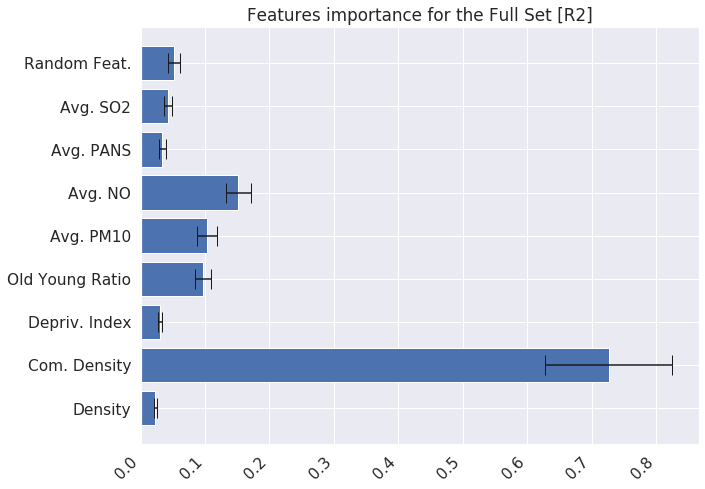

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

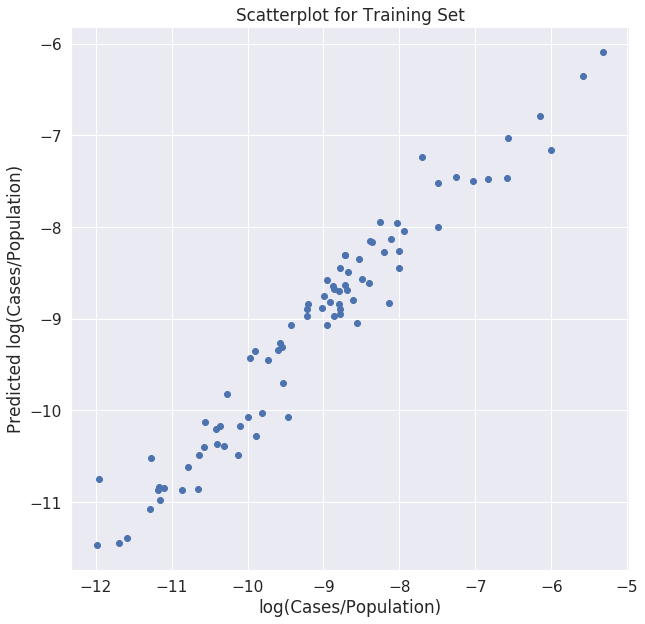

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

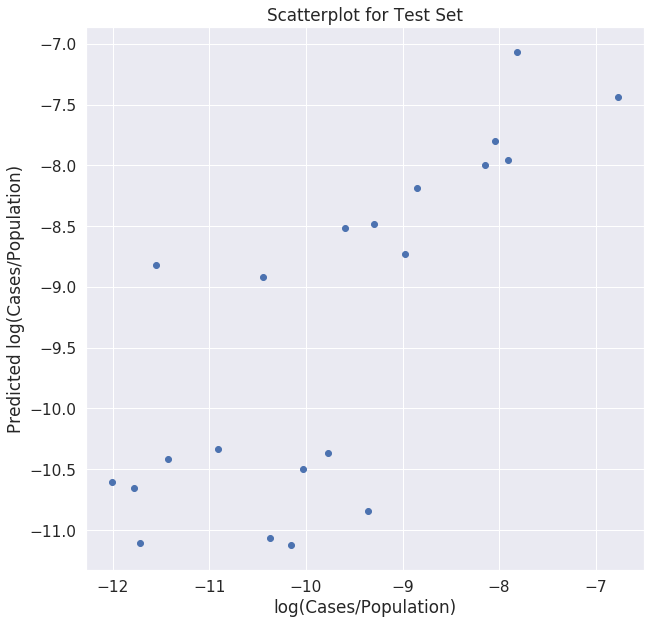

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.03369 +/- 0.03552
Feature:               commutersdensity, Score: 1.63272 +/- 0.54971
Feature:                         depriv, Score: -0.02482 +/- 0.05416
Feature:                 Ratio0200ver65, Score: 0.19930 +/- 0.09847
Feature:         avg_wpm10_period1_2020, Score: 0.04252 +/- 0.04451
Feature:           avg_wno_period1_2020, Score: 0.11046 +/- 0.07949
Feature:         avg_wpans_period1_2020, Score: 0.03914 +/- 0.03768
Feature:          avg_wso2_period1_2020, Score: -0.03194 +/- 0.02984
Feature:                  randomfeature, Score: 0.02241 +/- 0.03978


<Figure size 432x288 with 0 Axes>

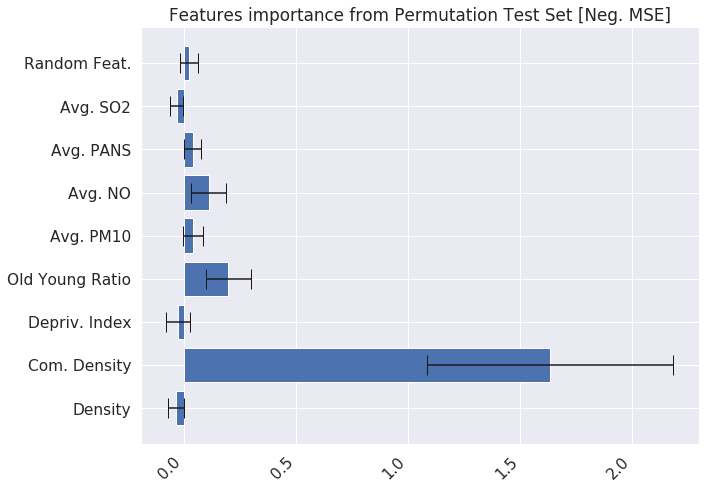

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.01573 +/- 0.01658
Feature:               commutersdensity, Score: 0.76231 +/- 0.25666
Feature:                         depriv, Score: -0.01159 +/- 0.02529
Feature:                 Ratio0200ver65, Score: 0.09305 +/- 0.04597
Feature:         avg_wpm10_period1_2020, Score: 0.01985 +/- 0.02078
Feature:           avg_wno_period1_2020, Score: 0.05157 +/- 0.03712
Feature:         avg_wpans_period1_2020, Score: 0.01828 +/- 0.01759
Feature:          avg_wso2_period1_2020, Score: -0.01491 +/- 0.01393
Feature:                  randomfeature, Score: 0.01046 +/- 0.01857


<Figure size 432x288 with 0 Axes>

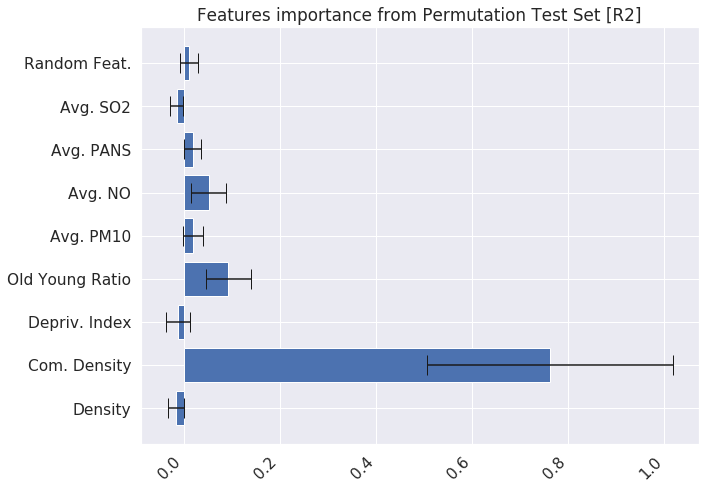

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07468 +/- 0.01308
Feature:               commutersdensity, Score: 1.78571 +/- 0.28862
Feature:                         depriv, Score: 0.08782 +/- 0.01733
Feature:                 Ratio0200ver65, Score: 0.22914 +/- 0.04005
Feature:         avg_wpm10_period1_2020, Score: 0.15896 +/- 0.03030
Feature:           avg_wno_period1_2020, Score: 0.21536 +/- 0.04121
Feature:         avg_wpans_period1_2020, Score: 0.09601 +/- 0.01675
Feature:          avg_wso2_period1_2020, Score: 0.07146 +/- 0.00802
Feature:                  randomfeature, Score: 0.14145 +/- 0.02135


<Figure size 432x288 with 0 Axes>

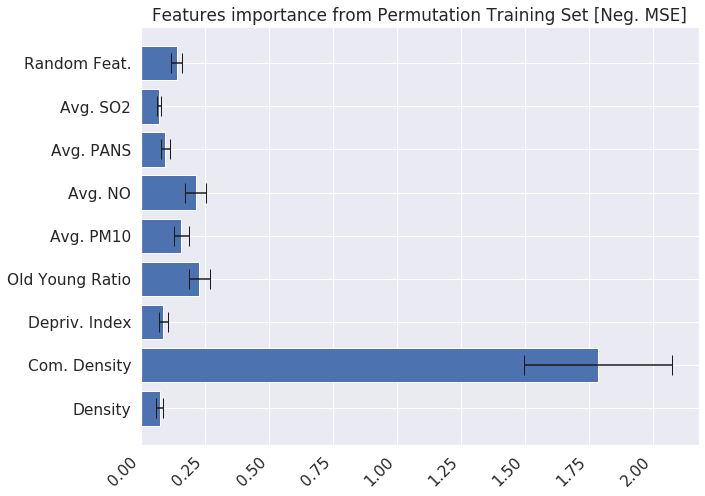

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03530 +/- 0.00618
Feature:               commutersdensity, Score: 0.84408 +/- 0.13643
Feature:                         depriv, Score: 0.04151 +/- 0.00819
Feature:                 Ratio0200ver65, Score: 0.10831 +/- 0.01893
Feature:         avg_wpm10_period1_2020, Score: 0.07514 +/- 0.01432
Feature:           avg_wno_period1_2020, Score: 0.10180 +/- 0.01948
Feature:         avg_wpans_period1_2020, Score: 0.04538 +/- 0.00792
Feature:          avg_wso2_period1_2020, Score: 0.03378 +/- 0.00379
Feature:                  randomfeature, Score: 0.06686 +/- 0.01009


<Figure size 432x288 with 0 Axes>

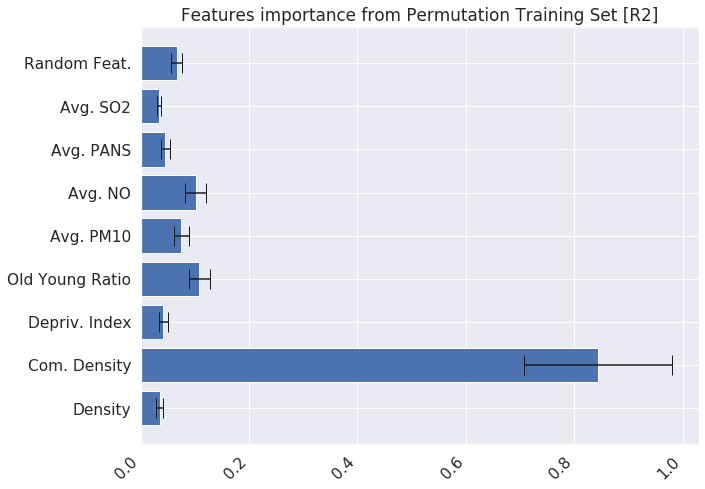

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_opttest_set", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.61747  0.03762 
    Test set average RMSE:  1.07727  0.11005 

Prediction STD :  1.083287621806711
True value STD:   1.4782591096169262
Difference in percentage:  26.71869127953946

             Fullset RMSE:  0.63557
                       R2:  0.81515


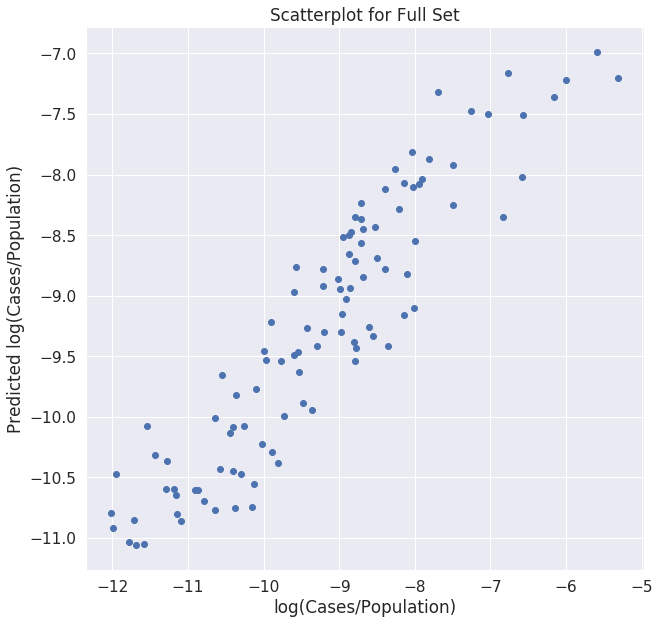

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06914 +/- 0.00715
Feature:                         depriv, Score: 0.49676 +/- 0.07652
Feature:                 Ratio0200ver65, Score: 0.19393 +/- 0.02691
Feature:         avg_wpm10_period1_2020, Score: 0.40992 +/- 0.05663
Feature:           avg_wno_period1_2020, Score: 1.01076 +/- 0.12441
Feature:         avg_wpans_period1_2020, Score: 0.12563 +/- 0.01792
Feature:          avg_wso2_period1_2020, Score: 0.09540 +/- 0.01071
Feature:                  randomfeature, Score: 0.10695 +/- 0.01528


<Figure size 432x288 with 0 Axes>

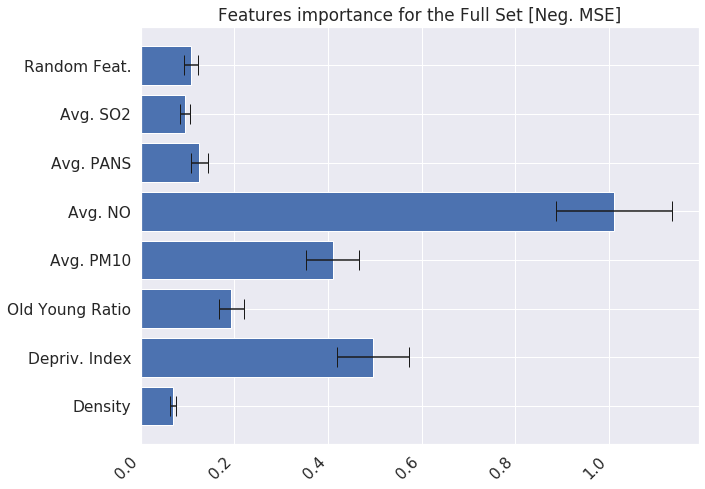

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        density, Score: 0.03164 +/- 0.00327
Feature:                         depriv, Score: 0.22732 +/- 0.03502
Feature:                 Ratio0200ver65, Score: 0.08874 +/- 0.01232
Feature:         avg_wpm10_period1_2020, Score: 0.18758 +/- 0.02591
Feature:           avg_wno_period1_2020, Score: 0.46254 +/- 0.05693
Feature:         avg_wpans_period1_2020, Score: 0.05749 +/- 0.00820
Feature:          avg_wso2_period1_2020, Score: 0.04366 +/- 0.00490
Feature:                  randomfeature, Score: 0.04894 +/- 0.00699


<Figure size 432x288 with 0 Axes>

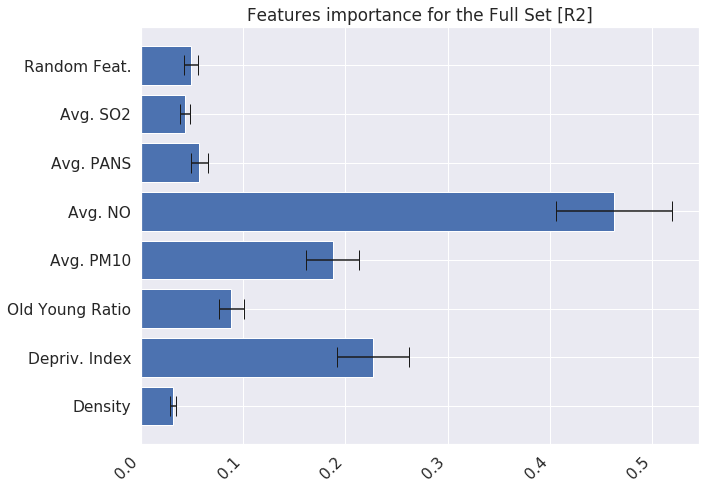

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

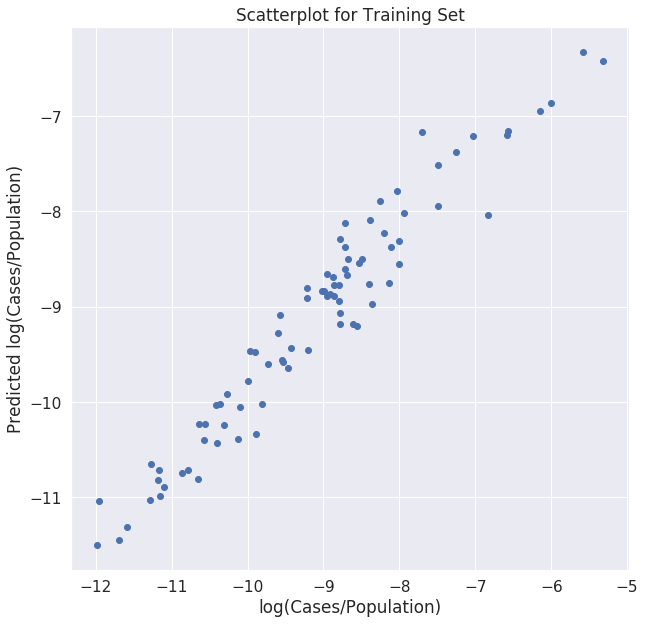

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

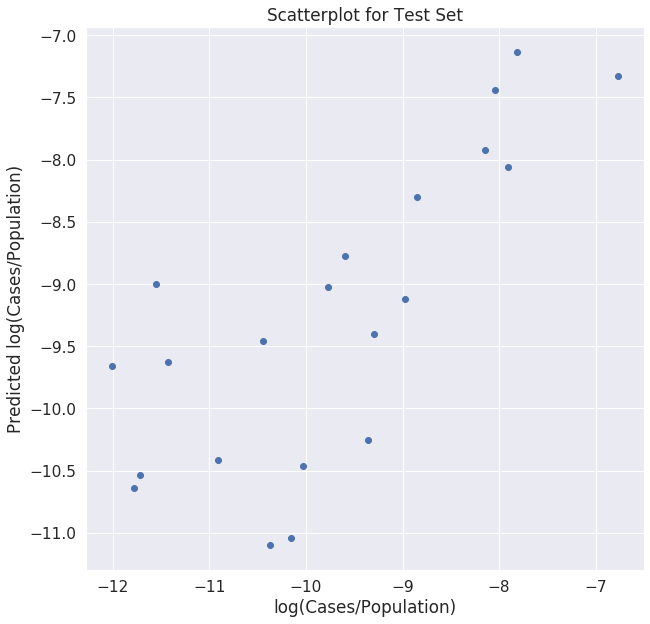

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        density, Score: -0.00496 +/- 0.03487
Feature:                         depriv, Score: 0.43126 +/- 0.26112
Feature:                 Ratio0200ver65, Score: 0.01867 +/- 0.03994
Feature:         avg_wpm10_period1_2020, Score: 0.30046 +/- 0.13683
Feature:           avg_wno_period1_2020, Score: 0.56864 +/- 0.21858
Feature:         avg_wpans_period1_2020, Score: 0.06988 +/- 0.07650
Feature:          avg_wso2_period1_2020, Score: -0.01424 +/- 0.03332
Feature:                  randomfeature, Score: -0.05317 +/- 0.04118


<Figure size 432x288 with 0 Axes>

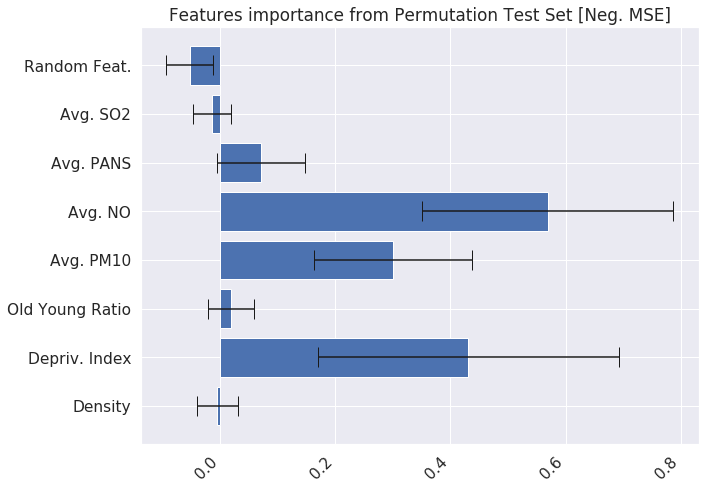

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        density, Score: -0.00231 +/- 0.01628
Feature:                         depriv, Score: 0.20135 +/- 0.12192
Feature:                 Ratio0200ver65, Score: 0.00872 +/- 0.01865
Feature:         avg_wpm10_period1_2020, Score: 0.14029 +/- 0.06388
Feature:           avg_wno_period1_2020, Score: 0.26550 +/- 0.10206
Feature:         avg_wpans_period1_2020, Score: 0.03262 +/- 0.03572
Feature:          avg_wso2_period1_2020, Score: -0.00665 +/- 0.01556
Feature:                  randomfeature, Score: -0.02483 +/- 0.01923


<Figure size 432x288 with 0 Axes>

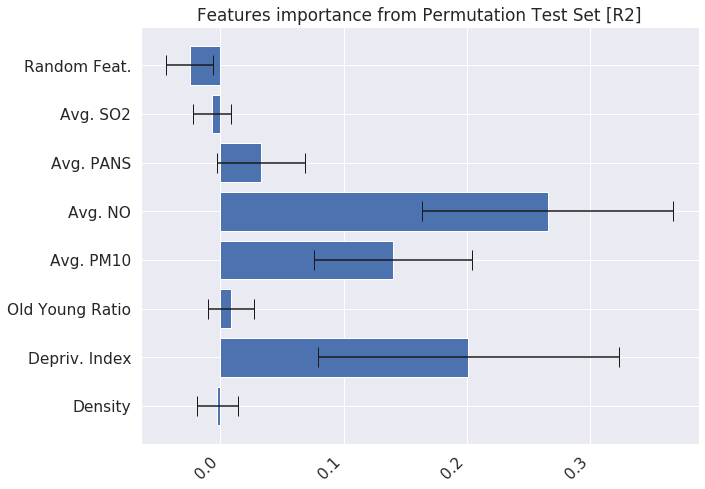

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06574 +/- 0.00960
Feature:                         depriv, Score: 0.97508 +/- 0.14784
Feature:                 Ratio0200ver65, Score: 0.14082 +/- 0.02488
Feature:         avg_wpm10_period1_2020, Score: 0.35501 +/- 0.06803
Feature:           avg_wno_period1_2020, Score: 0.56515 +/- 0.10766
Feature:         avg_wpans_period1_2020, Score: 0.13232 +/- 0.02062
Feature:          avg_wso2_period1_2020, Score: 0.06844 +/- 0.00865
Feature:                  randomfeature, Score: 0.15186 +/- 0.02150


<Figure size 432x288 with 0 Axes>

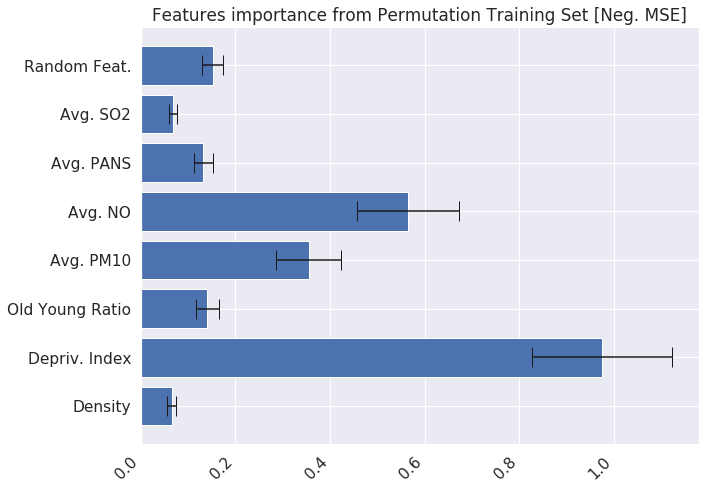

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        density, Score: 0.03107 +/- 0.00454
Feature:                         depriv, Score: 0.46090 +/- 0.06988
Feature:                 Ratio0200ver65, Score: 0.06656 +/- 0.01176
Feature:         avg_wpm10_period1_2020, Score: 0.16781 +/- 0.03216
Feature:           avg_wno_period1_2020, Score: 0.26713 +/- 0.05089
Feature:         avg_wpans_period1_2020, Score: 0.06254 +/- 0.00975
Feature:          avg_wso2_period1_2020, Score: 0.03235 +/- 0.00409
Feature:                  randomfeature, Score: 0.07178 +/- 0.01016


<Figure size 432x288 with 0 Axes>

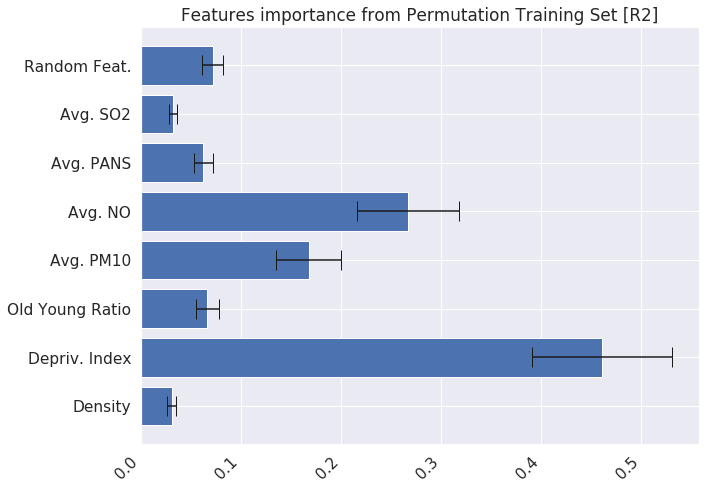

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="rf_model_nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)